In [1]:
import os
import sys
from IPython.display import HTML, display

import numpy as np
import pandas as pd
import tensorflow as tf
from math import ceil
from scipy.spatial.distance import cosine

import matplotlib.pyplot as plt
import seaborn as sns

import collections
import random
import time
import string
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Dense, Convolution1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dropout, LSTM, GRU,Bidirectional

[nltk_data] Downloading package stopwords to /Users/pjw22/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/pjw22/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/pjw22/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 1. Data Processing and Train-Validation-Test Split

In [2]:
df_label = pd.read_csv('/Users/pjw22/Desktop/BU Course/815/NLP_app/MutualFundLabels.csv')

In [3]:
df_label.head()

,id,fund_name,Performance fee?,Ivestment Strategy,Leverage?,Portfolio composition,Concentration
0,0000051931-18-000151,American Funds College 2018 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified
1,0000051931-18-000151,American Funds College 2021 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified
2,0000051931-18-000151,American Funds College 2024 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified
3,0000051931-18-000151,American Funds College 2027 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified
4,0000051931-18-000151,American Funds College 2030 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified


In [4]:
df_label['Ivestment Strategy'].value_counts()

Equity Long Only (Low Risk)          248
Fixed Income Long Only (Low Risk)    130
Balanced Fund (Low Risk)              84
Long Short Funds (High Risk)           4
Commodities Fund (Low Risk)            1
Name: Ivestment Strategy, dtype: int64

In [5]:
df_label = df_label[df_label['Ivestment Strategy'] != 'Commodities Fund (Low Risk)']

In [6]:
df_label['Ivestment Strategy'].value_counts()

Equity Long Only (Low Risk)          248
Fixed Income Long Only (Low Risk)    130
Balanced Fund (Low Risk)              84
Long Short Funds (High Risk)           4
Name: Ivestment Strategy, dtype: int64

In [7]:
# Progress bar
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))


# read the repo in PATH and append the texts in a list
def get_data(PATH):
    list_dir = os.listdir(PATH)
    texts = []
    fund_names = []
    out = display(progress(0, len(list_dir)-1), display_id=True)
    for ii, filename in enumerate(list_dir) :
        with open(PATH+'/'+filename, 'r', encoding="utf8") as f :
            txt = f.read()
            try :
                txt_split = txt.split('<head_breaker>')
                summary = txt_split[1].strip()
                fund_name = txt_split[0].strip()
            except :
                summary = txt
                fund_name = ''
        texts.append(summary)
        fund_names.append(fund_name)
        out.update(progress(ii, len(list_dir)-1))
    return fund_names, texts

In [8]:
# Get the summaries
fund_names, summaries = get_data('/Users/pjw22/Desktop/BU Course/815/NLP_app/MutualFundSummary')

In [9]:
summaries[0]

'Investment Objective\nThrivent Partner Healthcare Portfolio (the "Portfolio") seeks long-term capital growth.\nFees and Expenses\nThis table describes the fees and expenses that you may pay if you buy and hold shares of the Portfolio. If you own a variable annuity contract or variable life insurance contract, you will have additional expenses including mortality and expense risk charges. Please refer to the prospectus for your variable contract for additional information about charges for those contracts.\nSHAREHOLDER FEES\n(fees paid directly from your investment)\nMaximum Sales Charge (load) Imposed On Purchases (as a percentage of offering price)\tN/A\nMaximum Deferred Sales Charge (load) (as a percentage of the net asset value at time of purchase or redemption, whichever is lower)\tN/A\nANNUAL PORTFOLIO OPERATING EXPENSES\n(expenses that you pay each year as a percentage of\nthe value of your investment)\nManagement Fees\t0.83%\nOther Expenses\t0.10%\nTotal Annual Portfolio Operat

In [10]:
# We create here the dataframe that contains the summaries along with their labels
df_extraction = pd.DataFrame({'fund_name' : fund_names, 'summary':summaries})
#df_label = pd.read_csv(SUMMARY_LABELS_PATH)
df = df_label.merge(df_extraction, on='fund_name', how='left').dropna()
df.head()

,id,fund_name,Performance fee?,Ivestment Strategy,Leverage?,Portfolio composition,Concentration,summary
0,0000051931-18-000151,American Funds College 2018 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2018 Fund\n\nInvestment...
1,0000051931-18-000151,American Funds College 2021 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2021 Fund\n\nInvestment...
2,0000051931-18-000151,American Funds College 2024 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2024 Fund\n\nInvestment...
3,0000051931-18-000151,American Funds College 2027 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2027 Fund\n\nInvestment...
4,0000051931-18-000151,American Funds College 2030 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2030 Fund\n\nInvestment...


In [11]:
# train test validation split, adjust the random state to make sure every set contains a long short sample

df_train, df_test = train_test_split(df, test_size = 0.2, random_state=48)
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=40)

In [12]:
train_summaries = list(df_train['summary'])

In [13]:
df_train['Ivestment Strategy'].value_counts()

Equity Long Only (Low Risk)          153
Fixed Income Long Only (Low Risk)     89
Balanced Fund (Low Risk)              53
Long Short Funds (High Risk)           2
Name: Ivestment Strategy, dtype: int64

In [14]:
df_val['Ivestment Strategy'].value_counts()

Equity Long Only (Low Risk)          44
Fixed Income Long Only (Low Risk)    18
Balanced Fund (Low Risk)             12
Long Short Funds (High Risk)          1
Name: Ivestment Strategy, dtype: int64

In [15]:
df_test['Ivestment Strategy'].value_counts()

Equity Long Only (Low Risk)          50
Fixed Income Long Only (Low Risk)    23
Balanced Fund (Low Risk)             19
Long Short Funds (High Risk)          1
Name: Ivestment Strategy, dtype: int64

# 2. Train the Skip-Gram Model and Build Dictionary

In [16]:
stop_words = set(stopwords.words("english")+list(string.punctuation)+['``',"''"]+["]","[","*"]+['doe', 'ha', 'wa'])

In [17]:
# clean and tokenize the text -> we don't want to lemmatize
def tokenizer(txt):
    txt = txt.replace('\n', ' ').replace('\t', ' ').lower()
    word_tokens = word_tokenize(txt)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = [w for w in filtered_sentence if re.sub("[^A-Za-z ]+",'',w) != ''] 
    return filtered_sentence

In [18]:
text_words = np.concatenate([tokenizer(summary) for summary in train_summaries])

In [19]:
# Training Parameters
batch_size = 128 # The model will be trained batch per batch and one batch contains 128 rows
num_epochs = 2 # The model will go through all the data twice


# Word2Vec Parameters
embedding_size = 50 # Dimension of the embedding vector
max_vocabulary_size = 5000 # Total number of different words in the vocabulary
min_occurrence = 10 # Remove all words that does not appears at least n times
skip_window = 3 # How many words to consider left and right
num_skips = 4 # How many times to reuse an input to generate a label

In [20]:
# Build the dictionary and replace rare words with UNK token
count = [('UNK', -1)]
# Retrieve the most common words
count.extend(collections.Counter(text_words).most_common(max_vocabulary_size - 1))
# Remove samples with less than 'min_occurrence' occurrences
for i in range(len(count) - 1, -1, -1):
    if count[i][1] < min_occurrence:
        count.pop(i)
    else:
        # The collection is ordered, so stop when 'min_occurrence' is reached
        break

In [21]:
word2id = dict()
for i, (word, _)in enumerate(count):
    word2id[word] = i
id2word = dict(zip(word2id.values(), word2id.keys()))
vocab_size = len(id2word)

In [22]:
# create data
data = list()
unk_count = 0
for word in text_words:
    # Retrieve a word id, or assign it index 0 ('UNK') if not in dictionary
    index = word2id.get(word, 0)
    if index == 0:
        unk_count += 1
    data.append(index)
count[0] = ('UNK', unk_count)

In [23]:
# build OneHot vector from index
def to_one_hot(data_point_index, vocab_size):
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    return temp

In [24]:
# Generate training batch for the skip-gram model
def batch_generator(batch_size, num_skips, skip_window, vocab_size):
    data_index = 0
    while True :
        assert batch_size % num_skips == 0
        assert num_skips <= 2 * skip_window
        # batch is filled with 128 inputs
        batch = np.ndarray(shape=(batch_size), dtype=np.int32)
        # labels is filled with 128 outputs 
        labels = np.ndarray(shape=(batch_size), dtype=np.int32)
        span = 2 * skip_window + 1
        # buffer keep track of the visited indexes visited
        buffer = collections.deque(maxlen=span)
        if data_index + span > len(data):
            data_index = 0
            # We stop the loop when we went through all the corpus
            break
        buffer.extend(data[data_index:data_index + span])
        data_index += span
        for i in range(batch_size // num_skips):  
            # Take the context current word
            context_words = [w for w in range(span) if w != skip_window]
            # Randomly select num_skips words in the context
            words_to_use = random.sample(context_words, num_skips)
            for j, context_word in enumerate(words_to_use):
                # Creates one raw data
                batch[i * num_skips + j] = buffer[skip_window]
                labels[i * num_skips + j] = buffer[context_word]
            if data_index == len(data):
                buffer.extend(data[0:span])
                data_index = span
            else:
                buffer.append(data[data_index])
                data_index += 1
        # Backtrack a little bit to avoid skipping words in the end of a batch
        data_index = (data_index + len(data) - span) % len(data)

        # translate word index to on-hot representation
        batch_one_hot = np.array([to_one_hot(b, vocab_size) for b in batch])
        labels_one_hot = np.array([to_one_hot(l, vocab_size) for l in labels])

        # output one batch
        yield batch_one_hot, labels_one_hot

In [25]:
# Create en compile the Autoencoder
def creat_word2vec_model():
    input_word = Input(shape=(vocab_size,))

    encoded = Dense(embedding_size, activation='linear')(input_word)
    decoded = Dense(vocab_size, activation='softmax')(encoded)

    # The autoencoder is the whole model with hidden layer contected to the output layer.
    autoencoder = Model(input_word, decoded)
    # The encoder is just the input layer connected to the hidden layer. One the Autoencoder will be trained we will use
    # the encoder to create our word vectors 
    encoder = Model(input_word, encoded)
    
    #autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    autoencoder.compile(optimizer='adam', loss='categorical_crossentropy')
    return encoder, autoencoder

In [26]:
# We create the model
encoder, autoencoder = creat_word2vec_model()

In [27]:
autoencoder.fit_generator(batch_generator(batch_size, num_skips, skip_window, vocab_size), steps_per_epoch=ceil(len(data) / batch_size), epochs=num_epochs)

Epoch 1/2


/var/folders/l_/7bxj1ry51hbcvpybp93hdq4w0000gn/T/ipykernel_46970/486976267.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  autoencoder.fit_generator(batch_generator(batch_size, num_skips, skip_window, vocab_size), steps_per_epoch=ceil(len(data) / batch_size), epochs=num_epochs)
2023-05-05 10:43:14.271464: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


4124/4124 [==============================] - 13s 3ms/step - loss: 6.5602
Epoch 2/2
4124/4124 [==============================] - 12s 3ms/step - loss: 6.0103


In [28]:
my_path= '/Users/pjw22/Desktop/BU Course/815/NLP_app'

In [29]:
# Save a word2vec dictionary.
def save_word2vec(filename):
    with open(os.path.join(my_path, filename),'a' , encoding='utf-8') as f :
    #with open(os.path.join('/Users/haoxing/Documents/Work/Teaching/Machine learning for Finance/Codes/NLP/NLP_app', filename),'a' , encoding='utf-8') as f :
        for k, v in word2vec.items():
            line = k+' '+str(list(v)).strip('[]').replace(',','')+'\n'
            f.write(line)

# Load a word2vec dictionary.
def load_word2vec(filename):
    word2vec = {}
    with open(os.path.join(my_path, filename), encoding='utf8') as f:
    #with open(os.path.join('/Users/haoxing/Documents/Work/Teaching/Machine learning for Finance/Codes/NLP/NLP_app', filename), encoding='utf8') as f:
        for line in f:
            try :
                values = line.split()
                word = values[0]
                vec = np.asarray(values[1:], dtype='float32')
                word2vec[word] = vec
            except :
                None
    return word2vec

In [30]:
# Create the Vectorizer function (prediciton of the encoder)
def vecotrize(word):
    word_one_hot = to_one_hot(word2id[word], vocab_size)
    return encoder.predict(np.array([word_one_hot]))[0]


# Create the word2vec dictionary
word2vec = {w : vecotrize(w) for w in word2id.keys()}

# This dictionary gives for all words it's vectorial representation.


our_word2vec = 'word2vec_perso.txt'

# We can save the word2vec dictionary to reuse it later.
save_word2vec(our_word2vec)

1/1 [==============================] - 0s 11ms/step


In [31]:
# for a given word, output the n closer words in the word2vec maping.
def get_n_closer(w, n, word2vec):
    vect = word2vec[w]
    distances_dict = {k: cosine(v, vect) for k, v in word2vec.items()}
    
    closer_words = []
    for _ in range(n):
        min_key = min(distances_dict.keys(), key=lambda k: distances_dict[k])
        closer_words.append(min_key)
        del distances_dict[min_key]
    return closer_words

# 3. Design Knowledge Base

In [32]:
# keywords for “Balanced Fund (Low Risk)”
key_words1 = ['portfolio', 'balanced', 'asset', 'diversification', 'risk', 'low', 'investment', 'strategy', 'fixed', 'income', 'equity', 'return', 'fund', 'conservative', 'market']

# keywords for “Fixed Income Long Only (Low Risk)”
key_words2 = ['portfolio', 'risk', 'low', 'investment', 'strategy', 'cash', 'fixed', 'income', 'bond', 'yield', 'credit', 'maturity', 'duration', 'treasury', 'interest', 'rate', 'corporate', 'inflation', 'economic']

# keywords for “Equity Long Only (Low Risk)”
key_words3 = ['equity', 'stocks', 'securities', 'earnings', 'dividend', 'financial', 'statement', 'revenue', 'price', 'volatility', 'fund', 'company', 'industry', 'economic', 'growth', 'sector', 'strategy', 'risk', 'portfolio', 'factor']

# keywords for “Long Short Funds (High Risk)”
key_words4 = ['stock', 'derivatives', 'short', 'long', 'leverage', 'risk', 'option', 'future', 'loan', 'margin', 'volatility', 'selling', 'stock', 'fixed', 'income', 'exchange', 'rate', 'currency']

In [33]:
# Creates the knwoledge base by taking the num_neighbors closes neighbors of each key_words in word2vec
def create_knowledge_base(num_neighbors, word2vec, key_words):
    knowledge_base = set()
    out = display(progress(0, len(key_words)-1), display_id=True)
    for ii, key_word in enumerate(key_words) :
        knowledge_base.add(key_word)
        neighbors = []
        try :
            neighbors = get_n_closer(key_word, num_neighbors, word2vec)
        except :
            print(key_word + ' not in word2vec')

        knowledge_base.update(neighbors)
        
        out.update(progress(ii, len(key_words)-1))
    return knowledge_base

In [34]:
#word2vec = load_word2vec(our_word2vec)
knowledge_base1 = create_knowledge_base(5, word2vec, key_words1)
knowledge_base2 = create_knowledge_base(5, word2vec, key_words2)
knowledge_base3 = create_knowledge_base(5, word2vec, key_words3)
knowledge_base4 = create_knowledge_base(5, word2vec, key_words4)

In [35]:
knowledge_base = knowledge_base1.union(knowledge_base2).union(knowledge_base3).union(knowledge_base4)

In [36]:
print(knowledge_base)

{'stocks', 'flow', 'behalf', 'avoid', 'projects', 'things', 'investment', 'advisers', 'corporate', 'bbb-', 'sai', 'june', 'advisor', 'declining', 'managers', 'jpmorgan', 'managed', 'prevailing', 'economic', 'means', 'debt', 'weightings', 'decisions', 'earlier', 'movements', 'short', 'factor', 'page', 'maturity', 'duration', 'revenue', 'selected', 'iico', 'underperform', 'intermediary', 'terms', 'gross', 'attractively', 'company', 'manages', 'entails', 'section', 'summary', 'treasury', 'loss', 'currency', 'increases', 'loan', 'year-to-date', 'statement', 'commodity', 'conservative', 'parent', 'hypothetically', 'prepayment', 'fluctuations', 'serves', 'force', 'backed', 'bond', 'equity', 'monitor', 'financing', 'managing', 'reason', 'multi-manager', 'derivatives', 'conduct', 'mortgage', 'electronic', 'linked', 'performs', 'credit', 'turnover', 'low', 'dollar', 'developments', 'governing', 'potentially', 'risk', 'reward', 'preferred', 'designed', 'interconnected', 'particularly', 'imi', 'e

In [37]:
# Takes a summary, the knowledge base and some hyper parameters and returns the "num_sent" sentences
# of the summary that are closer to the the knowledge base in term of spacial distances.
def extract_sentence_distance(summary, knowledge, n_closer, n_reject, num_sent):
    # Split the summary into sentences.
    sentences = sent_tokenize(summary)
    sentence_scores = []
    # Loop over the sentences.
    for j, sentence in enumerate(sentences):
        # we tokenize and clean the sentence
        tokens = tokenizer(sentence)

        sentence_barycentre = np.zeros(embedding_size)
        effective_len = 0
        # Compute the barycentre of the sentence
        for token in tokens :
            try :
                sentence_barycentre += np.array(word2vec[token])
                effective_len += 1
            except KeyError :
                pass
            except :
                raise
        
        # Reject sentences with less than n_reject words in our word2vec map
        if effective_len <= n_reject :
            sentence_scores.append(1)    

        else :
            sentence_barycentre = sentence_barycentre/effective_len
            # Compute the distance sentece_barycentre -> words in our knowledge base
            barycentre_distance = [cosine(sentence_barycentre, word2vec[key_word]) for key_word in knowledge]
            barycentre_distance.sort()
            # Create the score of the sentence by averaging the "n_closer" smallest distances
            score = np.mean(barycentre_distance[:n_closer])
            sentence_scores.append(score)
    # Select the "num_sent" sentences that have the smallest score (smallest distance score with the knowledge base)
    sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
    top_sentences = sentences[:num_sent]
    return ' '.join(top_sentences)

In [38]:
# It takes several minutes (5-10 minutes)
df_train['sentences_distance'] = df_train.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)

df_val['sentences_distance'] = df_val.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)

df_test['sentences_distance'] = df_test.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)


# 4. Construct Prediction Model

In [39]:
X_train = df_train['sentences_distance'].values
X_val = df_val['sentences_distance'].values
X_test = df_test['sentences_distance'].values

# X = df['deriv_sentences_distance'].values # uncomment to use the first sentence extraction method.
# Clean the texts
X_train = [' '.join(tokenizer(txt)) for txt in X_train]
X_val = [' '.join(tokenizer(txt)) for txt in X_val]
X_test = [' '.join(tokenizer(txt)) for txt in X_test]

X_train[0][:100]

'inflation rapid fluctuations inflation interest rates may continue negative effects economy securiti'

In [40]:
# one-hot for labels

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)

y_train = encoder.fit_transform(np.array(df_train['Ivestment Strategy']).reshape(-1,1))
y_val = encoder.fit_transform(np.array(df_val['Ivestment Strategy']).reshape(-1,1))
y_test = encoder.fit_transform(np.array(df_test['Ivestment Strategy']).reshape(-1,1))

print(y_train)

[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]


In [41]:
num_words = 2500 # Size of the vocabulary used. we only consider the 2500 most common words. The other words are removed from the texts.
maxlen = 150 # Number of word considered for each document. we cut or lengthen the texts to have texts of 150 words.
word_dimension = 50 # dimension of our word vectors.

In [42]:
glove_word2vec = '/Users/pjw22/Desktop/BU Course/815/NLP_app/glove.6B.50d.txt'
our_word2vec = '/Users/pjw22/Desktop/BU Course/815/NLP_app/word2vec_perso.txt'

In [43]:
word2vec_g = load_word2vec(glove_word2vec)

In [44]:
# The Tokenizer provided by the Keras library allows to perform such transformation.
keras_tokenizer = Tokenizer(num_words=num_words)
keras_tokenizer.fit_on_texts(X_train)
# word_index is the dictionary that contains the index of each words in our 2500 long vocabulary.
word_index = keras_tokenizer.word_index
sequences_train = keras_tokenizer.texts_to_sequences(X_train)
sequences_test = keras_tokenizer.texts_to_sequences(X_test)
sequences_val = keras_tokenizer.texts_to_sequences(X_val)

In [45]:
feature_train = pad_sequences(sequences_train, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_test = pad_sequences(sequences_test, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_val = pad_sequences(sequences_val, maxlen=maxlen, dtype=float, padding='post', truncating='post')

In [46]:
embedding_matrix = np.zeros((len(word_index) + 1, word_dimension))
for word, i in word_index.items():
    embedding_vector = word2vec_g.get(word)
    #embedding_vector = word2vec.get(word)   # uncomment to use our own word2vec
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

CNN model


In [173]:
def create_CNN_model():
    CNN = Sequential()
    # The Embedding layer takes the embedding matrix as an argument and transform the inputed the sequences of index to sequences of vectors.
    CNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=False))


    CNN.add(Convolution1D(64, 5, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))

    CNN.add(Convolution1D(32, 5, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))

    CNN.add(Flatten())
    CNN.add(Dense(units = 128 , activation = 'relu'))
    CNN.add(Dropout(0.5))

    #CNN.add(Dense(units = 1, activation = 'sigmoid'))
    CNN.add(Dense(units = 4, activation = 'sigmoid'))

    #CNN.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    CNN.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return CNN

In [174]:
CNN_model = create_CNN_model()

In [175]:
CNN_history = CNN_model.fit(feature_train, y_train, epochs=50, batch_size=16, validation_data=(feature_val, y_val))

Epoch 1/50
19/19 [==============================] - 0s 8ms/step - loss: 1.0807 - accuracy: 0.5421 - val_loss: 0.9315 - val_accuracy: 0.5867
Epoch 2/50
19/19 [==============================] - 0s 3ms/step - loss: 0.8864 - accuracy: 0.6397 - val_loss: 0.7926 - val_accuracy: 0.7200
Epoch 3/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6594 - accuracy: 0.7744 - val_loss: 0.6591 - val_accuracy: 0.7467
Epoch 4/50
19/19 [==============================] - 0s 4ms/step - loss: 0.4598 - accuracy: 0.8451 - val_loss: 0.6269 - val_accuracy: 0.8267
Epoch 5/50
19/19 [==============================] - 0s 4ms/step - loss: 0.3604 - accuracy: 0.8990 - val_loss: 0.5544 - val_accuracy: 0.8133
Epoch 6/50
19/19 [==============================] - 0s 4ms/step - loss: 0.3354 - accuracy: 0.8889 - val_loss: 0.5238 - val_accuracy: 0.8267
Epoch 7/50
19/19 [==============================] - 0s 5ms/step - loss: 0.2419 - accuracy: 0.9394 - val_loss: 0.5004 - val_accuracy: 0.8400
Epoch 8/50
19/19 [==

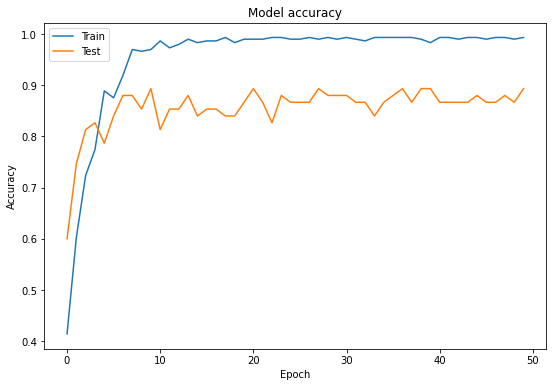

In [179]:
# Plot training & validation accuracy
plt.figure(figsize=(9,6))
plt.plot(CNN_history.history['accuracy'])
plt.plot(CNN_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

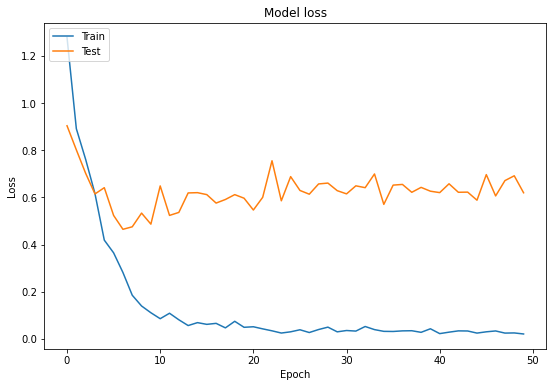

In [180]:
# Plot training & validation loss values
plt.figure(figsize=(9,6))
plt.plot(CNN_history.history['loss'])
plt.plot(CNN_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [176]:
y_pred_CNN = CNN_model.predict(feature_test)

3/3 [==============================] - 0s 3ms/step


In [177]:
y_pred_CNN_class = np.argmax(y_pred_CNN, axis=1)

In [178]:
y_pred_CNN_class

array([2, 2, 2, 1, 1, 2, 2, 0, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 0, 2,
       0, 1, 0, 1, 0, 2, 1, 2, 0, 2, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 2, 2, 2, 0, 0, 1, 1, 1, 2, 0, 1, 2, 1, 1, 2, 1, 2, 1, 2,
       2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 0,
       1, 2, 1, 1, 1])

In [179]:
y_test_class = np.argmax(y_test, axis=1)

In [180]:
accuracy_score(y_test_class, y_pred_CNN_class)

0.8817204301075269

In [181]:
print(classification_report(y_test_class, y_pred_CNN_class))

              precision    recall  f1-score   support

           0       0.87      0.68      0.76        19
           1       0.94      0.92      0.93        50
           2       0.79      1.00      0.88        23
           3       0.00      0.00      0.00         1

    accuracy                           0.88        93
   macro avg       0.65      0.65      0.64        93
weighted avg       0.88      0.88      0.87        93



/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 5. Hyperparameters Tuning on validation Data 

In this part, we tune the hyperparameters by Bayesian Optimization Tunning.

In [46]:
from bayes_opt import BayesianOptimization
from keras.optimizers import Adam, SGD, RMSprop, Adagrad
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold

In [47]:
# here we set the parameters list that we would like to optimize

optimizers_list = ['SGD', 'RMSprop', 'Adam', 'Adagrad']

activations_list = ['relu', 'elu', 'tanh', 'softplus']

learning_rates = (0.01, 1)

epochs = (20, 100)

batch_sizes = (5, 150)

In [48]:
def objective_func1(optimizer_index, activation_index, learning_rate, epoch, batch_size):

    optimizers_dict = {'SGD':SGD(lr=learning_rate), 'RMSprop':RMSprop(lr=learning_rate), 'Adam':Adam(lr=learning_rate), 'Adagrad':Adagrad(lr=learning_rate)}

    optimizer = optimizers_dict[optimizers_list[round(optimizer_index)]]
    activation = activations_list[round(activation_index)]

    def create_CNN_model():

        CNN = Sequential()
        # The Embedding layer takes the embedding matrix as an argument and transform the inputed the sequences of index to sequences of vectors.
        CNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=False))


        CNN.add(Convolution1D(64, 5, activation = activation))
        CNN.add(MaxPooling1D(pool_size = 5))

        CNN.add(Convolution1D(32, 5, activation = activation))
        CNN.add(MaxPooling1D(pool_size = 5))

        CNN.add(Flatten())
        CNN.add(Dense(units = 128 , activation = activation))
        CNN.add(Dropout(0.5))

        CNN.add(Dense(units = 4, activation = 'sigmoid'))

        CNN.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
        
        return CNN
    
    CNN_model = create_CNN_model()

    CNN_model.fit(feature_train, y_train, epochs=round(epoch), batch_size=round(batch_size), validation_data=(feature_val, y_val))
    
    #cnn = KerasClassifier(build_fn=CNN_model, epochs=epoch, batch_size=batch_size, verbose=0)

    y_pred_CNN = CNN_model.predict(feature_test)
    y_pred_CNN_class = np.argmax(y_pred_CNN, axis=1)

    return accuracy_score(y_test_class, y_pred_CNN_class)


In [186]:
params_cnn ={
    'optimizer_index':(0,3),
    'activation_index':(0, 3),
    'learning_rate':learning_rates,
    'epoch':epochs,
    'batch_size':batch_sizes
    
}

nn_bo = BayesianOptimization(objective_func1, params_cnn, random_state=110)
nn_bo.maximize(init_points=25, n_iter=3)

|   iter    |  target   | activa... | batch_... |   epoch   | learni... | optimi... |
-------------------------------------------------------------------------------------


/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50
3/3 [==============================] - 3s 239ms/step - loss: 267333.8125 - accuracy: 0.2559 - val_loss: 7.0912 - val_accuracy: 0.2400
Epoch 2/50
3/3 [==============================] - 0s 44ms/step - loss: 26.8142 - accuracy: 0.3434 - val_loss: 441.0152 - val_accuracy: 0.5867
Epoch 3/50
3/3 [==============================] - 0s 27ms/step - loss: 258.3643 - accuracy: 0.4882 - val_loss: 1.1480 - val_accuracy: 0.6000
Epoch 4/50
3/3 [==============================] - 0s 28ms/step - loss: 17.8773 - accuracy: 0.5084 - val_loss: 8.9715 - val_accuracy: 0.5867
Epoch 5/50
3/3 [==============================] - 0s 29ms/step - loss: 15.6616 - accuracy: 0.4882 - val_loss: 109.1707 - val_accuracy: 0.2933
Epoch 6/50
3/3 [==============================] - 0s 30ms/step - loss: 22.4117 - accuracy: 0.3603 - val_loss: 81.4631 - val_accuracy: 0.2800
Epoch 7/50
3/3 [==============================] - 0s 26ms/step - loss: 9.2630 - accuracy: 0.3805 - val_loss: 4.3139 - val_accuracy: 0.2800
Epoch 8/50

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/71
3/3 [==============================] - 1s 160ms/step - loss: 1.9148 - accuracy: 0.3165 - val_loss: 8.7443 - val_accuracy: 0.2400
Epoch 2/71
3/3 [==============================] - 0s 24ms/step - loss: 13.1502 - accuracy: 0.3805 - val_loss: 13.6191 - val_accuracy: 0.2400
Epoch 3/71
3/3 [==============================] - 0s 28ms/step - loss: 15.4896 - accuracy: 0.4040 - val_loss: 19.2587 - val_accuracy: 0.5867
Epoch 4/71
3/3 [==============================] - 0s 32ms/step - loss: 16.1977 - accuracy: 0.3468 - val_loss: 18.9282 - val_accuracy: 0.1600
Epoch 5/71
3/3 [==============================] - 0s 30ms/step - loss: 15.5290 - accuracy: 0.2929 - val_loss: 9.2128 - val_accuracy: 0.2400
Epoch 6/71
3/3 [==============================] - 0s 23ms/step - loss: 16.6089 - accuracy: 0.3670 - val_loss: 9.2768 - val_accuracy: 0.5867
Epoch 7/71
3/3 [==============================] - 0s 24ms/step - loss: 17.6547 - accuracy: 0.4175 - val_loss: 10.2185 - val_accuracy: 0.1600
Epoch 8/71
3/3 [

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


7/7 [==============================] - 1s 47ms/step - loss: 163.2249 - accuracy: 0.2694 - val_loss: 65.6634 - val_accuracy: 0.2400
Epoch 2/31
7/7 [==============================] - 0s 11ms/step - loss: 24.2296 - accuracy: 0.3569 - val_loss: 2.4184 - val_accuracy: 0.2533
Epoch 3/31
7/7 [==============================] - 0s 11ms/step - loss: 4.7168 - accuracy: 0.3569 - val_loss: 4.0795 - val_accuracy: 0.5867
Epoch 4/31
7/7 [==============================] - 0s 11ms/step - loss: 3.4782 - accuracy: 0.3838 - val_loss: 1.4364 - val_accuracy: 0.2533
Epoch 5/31
7/7 [==============================] - 0s 12ms/step - loss: 1.8423 - accuracy: 0.3636 - val_loss: 1.2650 - val_accuracy: 0.5867
Epoch 6/31
7/7 [==============================] - 0s 13ms/step - loss: 1.4613 - accuracy: 0.4579 - val_loss: 2.5397 - val_accuracy: 0.5867
Epoch 7/31
7/7 [==============================] - 0s 18ms/step - loss: 2.7899 - accuracy: 0.4613 - val_loss: 1.9883 - val_accuracy: 0.2400
Epoch 8/31
7/7 [==================

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


38/38 [==============================] - 1s 7ms/step - loss: 7237.7500 - accuracy: 0.4040 - val_loss: 6.6351 - val_accuracy: 0.4400
Epoch 2/65
38/38 [==============================] - 0s 3ms/step - loss: 12.2921 - accuracy: 0.3300 - val_loss: 193.0733 - val_accuracy: 0.5867
Epoch 3/65
38/38 [==============================] - 0s 3ms/step - loss: 271.1498 - accuracy: 0.2963 - val_loss: 12.2442 - val_accuracy: 0.2400
Epoch 4/65
38/38 [==============================] - 0s 3ms/step - loss: 6.2438 - accuracy: 0.3199 - val_loss: 14.9262 - val_accuracy: 0.2400
Epoch 5/65
38/38 [==============================] - 0s 3ms/step - loss: 10.9490 - accuracy: 0.3838 - val_loss: 2.5963 - val_accuracy: 0.5867
Epoch 6/65
38/38 [==============================] - 0s 3ms/step - loss: 6.2435 - accuracy: 0.3805 - val_loss: 15.9068 - val_accuracy: 0.2400
Epoch 7/65
38/38 [==============================] - 0s 3ms/step - loss: 9.5816 - accuracy: 0.3535 - val_loss: 7.7194 - val_accuracy: 0.5867
Epoch 8/65
38/38 [=

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3/3 [==============================] - 1s 114ms/step - loss: 1113815.7500 - accuracy: 0.2256 - val_loss: 29940300.0000 - val_accuracy: 0.5867
Epoch 2/68
3/3 [==============================] - 0s 24ms/step - loss: 18083972.0000 - accuracy: 0.3300 - val_loss: 2485983.2500 - val_accuracy: 0.5867
Epoch 3/68
3/3 [==============================] - 0s 25ms/step - loss: 1516880.0000 - accuracy: 0.3502 - val_loss: 16844.4219 - val_accuracy: 0.2667
Epoch 4/68
3/3 [==============================] - 0s 25ms/step - loss: 21592.0312 - accuracy: 0.3973 - val_loss: 7200.9199 - val_accuracy: 0.4933
Epoch 5/68
3/3 [==============================] - 0s 29ms/step - loss: 10243.9248 - accuracy: 0.4343 - val_loss: 3927.9907 - val_accuracy: 0.4800
Epoch 6/68
3/3 [==============================] - 0s 32ms/step - loss: 5916.2393 - accuracy: 0.4646 - val_loss: 3538.5212 - val_accuracy: 0.4000
Epoch 7/68
3/3 [==============================] - 0s 27ms/step - loss: 5856.1357 - accuracy: 0.4411 - val_loss: 2881.028

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


17/17 [==============================] - 1s 27ms/step - loss: 1306793.7500 - accuracy: 0.3973 - val_loss: 67.8356 - val_accuracy: 0.5733
Epoch 2/88
17/17 [==============================] - 0s 5ms/step - loss: 35.1323 - accuracy: 0.4478 - val_loss: 1.0644 - val_accuracy: 0.5867
Epoch 3/88
17/17 [==============================] - 0s 6ms/step - loss: 1.6020 - accuracy: 0.4848 - val_loss: 1.1251 - val_accuracy: 0.5867
Epoch 4/88
17/17 [==============================] - 0s 5ms/step - loss: 1.1151 - accuracy: 0.4646 - val_loss: 1.3911 - val_accuracy: 0.2400
Epoch 5/88
17/17 [==============================] - 0s 6ms/step - loss: 1.1221 - accuracy: 0.4714 - val_loss: 1.1151 - val_accuracy: 0.2400
Epoch 6/88
17/17 [==============================] - 0s 6ms/step - loss: 1.0995 - accuracy: 0.4680 - val_loss: 1.1956 - val_accuracy: 0.2400
Epoch 7/88
17/17 [==============================] - 0s 8ms/step - loss: 1.0993 - accuracy: 0.4545 - val_loss: 1.1132 - val_accuracy: 0.5867
Epoch 8/88
17/17 [====

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/51
4/4 [==============================] - 1s 102ms/step - loss: 80.7352 - accuracy: 0.3401 - val_loss: 171.3937 - val_accuracy: 0.2400
Epoch 2/51
4/4 [==============================] - 0s 27ms/step - loss: 92.2457 - accuracy: 0.3872 - val_loss: 61.9239 - val_accuracy: 0.1600
Epoch 3/51
4/4 [==============================] - 0s 19ms/step - loss: 83.6454 - accuracy: 0.3434 - val_loss: 13.9425 - val_accuracy: 0.2400
Epoch 4/51
4/4 [==============================] - 0s 26ms/step - loss: 47.1469 - accuracy: 0.3569 - val_loss: 82.7551 - val_accuracy: 0.2400
Epoch 5/51
4/4 [==============================] - 0s 23ms/step - loss: 62.8084 - accuracy: 0.3401 - val_loss: 54.3777 - val_accuracy: 0.2400
Epoch 6/51
4/4 [==============================] - 0s 24ms/step - loss: 51.2051 - accuracy: 0.4141 - val_loss: 17.6210 - val_accuracy: 0.2400
Epoch 7/51
4/4 [==============================] - 0s 21ms/step - loss: 35.8600 - accuracy: 0.3872 - val_loss: 90.4581 - val_accuracy: 0.2400
Epoch 8/51


/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


27/27 [==============================] - 1s 10ms/step - loss: 20.9359 - accuracy: 0.3737 - val_loss: 17.7224 - val_accuracy: 0.1600
Epoch 2/68
27/27 [==============================] - 0s 4ms/step - loss: 17.0012 - accuracy: 0.3603 - val_loss: 4.8868 - val_accuracy: 0.5867
Epoch 3/68
27/27 [==============================] - 0s 4ms/step - loss: 18.9972 - accuracy: 0.3535 - val_loss: 6.8331 - val_accuracy: 0.2400
Epoch 4/68
27/27 [==============================] - 0s 4ms/step - loss: 15.6899 - accuracy: 0.3737 - val_loss: 13.2102 - val_accuracy: 0.5867
Epoch 5/68
27/27 [==============================] - 0s 4ms/step - loss: 18.0459 - accuracy: 0.3502 - val_loss: 11.9852 - val_accuracy: 0.5867
Epoch 6/68
27/27 [==============================] - 0s 6ms/step - loss: 16.3507 - accuracy: 0.4040 - val_loss: 16.6587 - val_accuracy: 0.5867
Epoch 7/68
27/27 [==============================] - 0s 7ms/step - loss: 15.9446 - accuracy: 0.3670 - val_loss: 20.5592 - val_accuracy: 0.5867
Epoch 8/68
27/27 [

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3/3 [==============================] - 1s 148ms/step - loss: 63360444.0000 - accuracy: 0.2492 - val_loss: 852335488.0000 - val_accuracy: 0.0133
Epoch 2/83
3/3 [==============================] - 0s 47ms/step - loss: 367712320.0000 - accuracy: 0.2626 - val_loss: 3301561.2500 - val_accuracy: 0.1867
Epoch 3/83
3/3 [==============================] - 0s 27ms/step - loss: 2515113.5000 - accuracy: 0.2525 - val_loss: 155103.7969 - val_accuracy: 0.2800
Epoch 4/83
3/3 [==============================] - 0s 29ms/step - loss: 259424.4062 - accuracy: 0.3333 - val_loss: 50051.8711 - val_accuracy: 0.6000
Epoch 5/83
3/3 [==============================] - 0s 39ms/step - loss: 112705.5859 - accuracy: 0.4074 - val_loss: 29937.4141 - val_accuracy: 0.5733
Epoch 6/83
3/3 [==============================] - 0s 39ms/step - loss: 44901.8398 - accuracy: 0.4175 - val_loss: 17895.4590 - val_accuracy: 0.4533
Epoch 7/83
3/3 [==============================] - 0s 36ms/step - loss: 20332.7070 - accuracy: 0.4646 - val_los

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3/3 [==============================] - 1s 97ms/step - loss: 179.2894 - accuracy: 0.3704 - val_loss: 4587.3765 - val_accuracy: 0.5867
Epoch 2/35
3/3 [==============================] - 0s 27ms/step - loss: 10923.2773 - accuracy: 0.3064 - val_loss: 127.8634 - val_accuracy: 0.1733
Epoch 3/35
3/3 [==============================] - 0s 23ms/step - loss: 159.6419 - accuracy: 0.3367 - val_loss: 2.6494 - val_accuracy: 0.5867
Epoch 4/35
3/3 [==============================] - 0s 23ms/step - loss: 7.6654 - accuracy: 0.4074 - val_loss: 2.8278 - val_accuracy: 0.5333
Epoch 5/35
3/3 [==============================] - 0s 23ms/step - loss: 4.4580 - accuracy: 0.4411 - val_loss: 2.4428 - val_accuracy: 0.5867
Epoch 6/35
3/3 [==============================] - 0s 25ms/step - loss: 1.5248 - accuracy: 0.5320 - val_loss: 1.6967 - val_accuracy: 0.6000
Epoch 7/35
3/3 [==============================] - 0s 28ms/step - loss: 1.1185 - accuracy: 0.5354 - val_loss: 1.7087 - val_accuracy: 0.6133
Epoch 8/35
3/3 [=========

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3/3 [==============================] - 1s 98ms/step - loss: 1399.7009 - accuracy: 0.3333 - val_loss: 49.2325 - val_accuracy: 0.1600
Epoch 2/91
3/3 [==============================] - 0s 27ms/step - loss: 85.0642 - accuracy: 0.2391 - val_loss: 26.6017 - val_accuracy: 0.5867
Epoch 3/91
3/3 [==============================] - 0s 27ms/step - loss: 19.8041 - accuracy: 0.4343 - val_loss: 1.0968 - val_accuracy: 0.5867
Epoch 4/91
3/3 [==============================] - 0s 29ms/step - loss: 1.1581 - accuracy: 0.5152 - val_loss: 1.0434 - val_accuracy: 0.5867
Epoch 5/91
3/3 [==============================] - 0s 39ms/step - loss: 1.4355 - accuracy: 0.5084 - val_loss: 1.0515 - val_accuracy: 0.5867
Epoch 6/91
3/3 [==============================] - 0s 53ms/step - loss: 1.0659 - accuracy: 0.5152 - val_loss: 1.0389 - val_accuracy: 0.5867
Epoch 7/91
3/3 [==============================] - 0s 42ms/step - loss: 1.0593 - accuracy: 0.5152 - val_loss: 1.0384 - val_accuracy: 0.5867
Epoch 8/91
3/3 [===============

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3/3 [==============================] - 1s 94ms/step - loss: 1932.0995 - accuracy: 0.2054 - val_loss: 27344.8594 - val_accuracy: 0.4800
Epoch 2/59
3/3 [==============================] - 0s 24ms/step - loss: 42270.6289 - accuracy: 0.3535 - val_loss: 3280.3694 - val_accuracy: 0.3867
Epoch 3/59
3/3 [==============================] - 0s 23ms/step - loss: 2713.7949 - accuracy: 0.2189 - val_loss: 492.0898 - val_accuracy: 0.4000
Epoch 4/59
3/3 [==============================] - 0s 27ms/step - loss: 363.8551 - accuracy: 0.4108 - val_loss: 133.6006 - val_accuracy: 0.5733
Epoch 5/59
3/3 [==============================] - 0s 26ms/step - loss: 163.2567 - accuracy: 0.3771 - val_loss: 109.3128 - val_accuracy: 0.5867
Epoch 6/59
3/3 [==============================] - 0s 31ms/step - loss: 127.5403 - accuracy: 0.4040 - val_loss: 82.4886 - val_accuracy: 0.5867
Epoch 7/59
3/3 [==============================] - 0s 38ms/step - loss: 113.9780 - accuracy: 0.3737 - val_loss: 43.1954 - val_accuracy: 0.4267
Epoch

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3/3 [==============================] - 1s 91ms/step - loss: 47.2986 - accuracy: 0.3434 - val_loss: 124.9566 - val_accuracy: 0.5867
Epoch 2/52
3/3 [==============================] - 0s 27ms/step - loss: 189.1100 - accuracy: 0.2694 - val_loss: 149.8959 - val_accuracy: 0.5867
Epoch 3/52
3/3 [==============================] - 0s 29ms/step - loss: 107.7749 - accuracy: 0.4444 - val_loss: 62.1756 - val_accuracy: 0.5867
Epoch 4/52
3/3 [==============================] - 0s 39ms/step - loss: 46.7733 - accuracy: 0.3636 - val_loss: 41.9878 - val_accuracy: 0.5867
Epoch 5/52
3/3 [==============================] - 0s 26ms/step - loss: 36.1172 - accuracy: 0.3805 - val_loss: 78.7464 - val_accuracy: 0.5867
Epoch 6/52
3/3 [==============================] - 0s 31ms/step - loss: 108.2520 - accuracy: 0.4545 - val_loss: 47.5395 - val_accuracy: 0.2400
Epoch 7/52
3/3 [==============================] - 0s 34ms/step - loss: 54.3886 - accuracy: 0.3704 - val_loss: 58.9083 - val_accuracy: 0.5867
Epoch 8/52
3/3 [===

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


4/4 [==============================] - 1s 61ms/step - loss: 153692688.0000 - accuracy: 0.3131 - val_loss: 1707.8953 - val_accuracy: 0.2933
Epoch 2/34
4/4 [==============================] - 0s 17ms/step - loss: 19099.0332 - accuracy: 0.3805 - val_loss: 629.5252 - val_accuracy: 0.5200
Epoch 3/34
4/4 [==============================] - 0s 16ms/step - loss: 236.9534 - accuracy: 0.4714 - val_loss: 136.4186 - val_accuracy: 0.6267
Epoch 4/34
4/4 [==============================] - 0s 19ms/step - loss: 61.1194 - accuracy: 0.5387 - val_loss: 54.7888 - val_accuracy: 0.6267
Epoch 5/34
4/4 [==============================] - 0s 20ms/step - loss: 70.6979 - accuracy: 0.4848 - val_loss: 22.3273 - val_accuracy: 0.1333
Epoch 6/34
4/4 [==============================] - 0s 20ms/step - loss: 5.8366 - accuracy: 0.4310 - val_loss: 20.6508 - val_accuracy: 0.5467
Epoch 7/34
4/4 [==============================] - 0s 27ms/step - loss: 3.9108 - accuracy: 0.5455 - val_loss: 20.5197 - val_accuracy: 0.2800
Epoch 8/34


/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


4/4 [==============================] - 1s 64ms/step - loss: 12.1539 - accuracy: 0.3232 - val_loss: 1.0839 - val_accuracy: 0.4667
Epoch 2/88
4/4 [==============================] - 0s 17ms/step - loss: 1.0949 - accuracy: 0.4377 - val_loss: 0.9588 - val_accuracy: 0.5867
Epoch 3/88
4/4 [==============================] - 0s 16ms/step - loss: 1.0442 - accuracy: 0.5185 - val_loss: 0.9984 - val_accuracy: 0.5867
Epoch 4/88
4/4 [==============================] - 0s 17ms/step - loss: 1.0298 - accuracy: 0.5354 - val_loss: 0.9566 - val_accuracy: 0.5867
Epoch 5/88
4/4 [==============================] - 0s 16ms/step - loss: 0.9860 - accuracy: 0.4781 - val_loss: 0.9509 - val_accuracy: 0.5867
Epoch 6/88
4/4 [==============================] - 0s 25ms/step - loss: 0.9187 - accuracy: 0.5690 - val_loss: 0.9706 - val_accuracy: 0.5067
Epoch 7/88
4/4 [==============================] - 0s 31ms/step - loss: 0.8626 - accuracy: 0.6195 - val_loss: 0.8545 - val_accuracy: 0.6267
Epoch 8/88
4/4 [=====================

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


25/25 [==============================] - 1s 11ms/step - loss: 32.4112 - accuracy: 0.3737 - val_loss: 38.4812 - val_accuracy: 0.5867
Epoch 2/77
25/25 [==============================] - 0s 4ms/step - loss: 32.9235 - accuracy: 0.3973 - val_loss: 18.4856 - val_accuracy: 0.5867
Epoch 3/77
25/25 [==============================] - 0s 8ms/step - loss: 33.0124 - accuracy: 0.3603 - val_loss: 34.5781 - val_accuracy: 0.5867
Epoch 4/77
25/25 [==============================] - 0s 6ms/step - loss: 31.4360 - accuracy: 0.4108 - val_loss: 13.3688 - val_accuracy: 0.5867
Epoch 5/77
25/25 [==============================] - 0s 6ms/step - loss: 24.6348 - accuracy: 0.4545 - val_loss: 34.5025 - val_accuracy: 0.2400
Epoch 6/77
25/25 [==============================] - 0s 6ms/step - loss: 29.1827 - accuracy: 0.3906 - val_loss: 11.4070 - val_accuracy: 0.2400
Epoch 7/77
25/25 [==============================] - 0s 7ms/step - loss: 26.4076 - accuracy: 0.3939 - val_loss: 11.0307 - val_accuracy: 0.1600
Epoch 8/77
25/25

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2/2 [==============================] - 2s 845ms/step - loss: 32365710.0000 - accuracy: 0.1380 - val_loss: 23212956.0000 - val_accuracy: 0.2400
Epoch 2/81
2/2 [==============================] - 0s 65ms/step - loss: 136052784.0000 - accuracy: 0.2660 - val_loss: 9147841.0000 - val_accuracy: 0.5867
Epoch 3/81
2/2 [==============================] - 0s 87ms/step - loss: 11194239.0000 - accuracy: 0.3973 - val_loss: 1114546.6250 - val_accuracy: 0.5867
Epoch 4/81
2/2 [==============================] - 0s 135ms/step - loss: 729445.5000 - accuracy: 0.4815 - val_loss: 15908.7812 - val_accuracy: 0.5867
Epoch 5/81
2/2 [==============================] - 0s 89ms/step - loss: 23888.0547 - accuracy: 0.4747 - val_loss: 9411.5732 - val_accuracy: 0.5867
Epoch 6/81
2/2 [==============================] - 0s 146ms/step - loss: 23598.6758 - accuracy: 0.4545 - val_loss: 6975.8149 - val_accuracy: 0.5867
Epoch 7/81
2/2 [==============================] - 0s 70ms/step - loss: 13725.0117 - accuracy: 0.4310 - val_los

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


5/5 [==============================] - 36s 9s/step - loss: 1307.6616 - accuracy: 0.3737 - val_loss: 129663.0938 - val_accuracy: 0.2400
Epoch 2/58
5/5 [==============================] - 0s 31ms/step - loss: 24740.8359 - accuracy: 0.4108 - val_loss: 159.0459 - val_accuracy: 0.1333
Epoch 3/58
5/5 [==============================] - 0s 24ms/step - loss: 72.6877 - accuracy: 0.4108 - val_loss: 42.6168 - val_accuracy: 0.4000
Epoch 4/58
5/5 [==============================] - 0s 28ms/step - loss: 46.7463 - accuracy: 0.3670 - val_loss: 30.9146 - val_accuracy: 0.5867
Epoch 5/58
5/5 [==============================] - 0s 17ms/step - loss: 38.0901 - accuracy: 0.3805 - val_loss: 17.5011 - val_accuracy: 0.6000
Epoch 6/58
5/5 [==============================] - 0s 60ms/step - loss: 31.2152 - accuracy: 0.3906 - val_loss: 16.3680 - val_accuracy: 0.5733
Epoch 7/58
5/5 [==============================] - 0s 19ms/step - loss: 22.9859 - accuracy: 0.4141 - val_loss: 9.5091 - val_accuracy: 0.6133
Epoch 8/58
5/5 [

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 1s 29ms/step - loss: 2.3268 - accuracy: 0.3973 - val_loss: 2.3895 - val_accuracy: 0.5867
Epoch 2/32
8/8 [==============================] - 0s 9ms/step - loss: 2.3682 - accuracy: 0.3872 - val_loss: 2.0487 - val_accuracy: 0.5867
Epoch 3/32
8/8 [==============================] - 0s 9ms/step - loss: 1.7298 - accuracy: 0.4646 - val_loss: 2.4076 - val_accuracy: 0.2400
Epoch 4/32
8/8 [==============================] - 0s 9ms/step - loss: 1.7773 - accuracy: 0.4141 - val_loss: 4.3263 - val_accuracy: 0.1600
Epoch 5/32
8/8 [==============================] - 0s 9ms/step - loss: 2.7023 - accuracy: 0.3704 - val_loss: 1.7788 - val_accuracy: 0.2400
Epoch 6/32
8/8 [==============================] - 0s 17ms/step - loss: 1.3451 - accuracy: 0.4983 - val_loss: 1.5888 - val_accuracy: 0.5867
Epoch 7/32
8/8 [==============================] - 0s 12ms/step - loss: 1.2463 - accuracy: 0.4512 - val_loss: 4.2351 - val_accuracy: 0.1600
Epoch 8/32
8/8 [==========================

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3/3 [==============================] - 1s 105ms/step - loss: 9.6141 - accuracy: 0.4074 - val_loss: 117.7171 - val_accuracy: 0.2400
Epoch 2/21
3/3 [==============================] - 0s 23ms/step - loss: 85.1647 - accuracy: 0.3300 - val_loss: 7.4883 - val_accuracy: 0.1467
Epoch 3/21
3/3 [==============================] - 0s 29ms/step - loss: 29.9831 - accuracy: 0.3906 - val_loss: 26.3682 - val_accuracy: 0.5867
Epoch 4/21
3/3 [==============================] - 0s 26ms/step - loss: 31.9685 - accuracy: 0.3670 - val_loss: 44.1205 - val_accuracy: 0.5867
Epoch 5/21
3/3 [==============================] - 0s 25ms/step - loss: 28.8584 - accuracy: 0.4343 - val_loss: 18.4686 - val_accuracy: 0.2400
Epoch 6/21
3/3 [==============================] - 0s 28ms/step - loss: 27.4790 - accuracy: 0.3906 - val_loss: 21.9809 - val_accuracy: 0.5867
Epoch 7/21
3/3 [==============================] - 0s 29ms/step - loss: 33.9435 - accuracy: 0.4444 - val_loss: 10.9064 - val_accuracy: 0.1600
Epoch 8/21
3/3 [========

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3/3 [==============================] - 1s 96ms/step - loss: 28.5950 - accuracy: 0.2896 - val_loss: 91.3521 - val_accuracy: 0.5733
Epoch 2/51
3/3 [==============================] - 0s 24ms/step - loss: 114.9455 - accuracy: 0.3401 - val_loss: 114.5916 - val_accuracy: 0.2400
Epoch 3/51
3/3 [==============================] - 0s 23ms/step - loss: 125.9701 - accuracy: 0.4242 - val_loss: 38.9793 - val_accuracy: 0.1600
Epoch 4/51
3/3 [==============================] - 0s 32ms/step - loss: 78.6342 - accuracy: 0.3367 - val_loss: 88.9898 - val_accuracy: 0.5867
Epoch 5/51
3/3 [==============================] - 0s 27ms/step - loss: 77.2779 - accuracy: 0.4209 - val_loss: 39.7531 - val_accuracy: 0.2400
Epoch 6/51
3/3 [==============================] - 0s 38ms/step - loss: 51.6835 - accuracy: 0.4545 - val_loss: 40.1316 - val_accuracy: 0.5867
Epoch 7/51
3/3 [==============================] - 0s 60ms/step - loss: 50.7866 - accuracy: 0.3939 - val_loss: 20.8268 - val_accuracy: 0.5867
Epoch 8/51
3/3 [=====

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3/3 [==============================] - 1s 99ms/step - loss: 12.8974 - accuracy: 0.2290 - val_loss: 60.8214 - val_accuracy: 0.0133
Epoch 2/22
3/3 [==============================] - 0s 23ms/step - loss: 47.0913 - accuracy: 0.2862 - val_loss: 17.4568 - val_accuracy: 0.2800
Epoch 3/22
3/3 [==============================] - 0s 26ms/step - loss: 21.0692 - accuracy: 0.3771 - val_loss: 8.9790 - val_accuracy: 0.1733
Epoch 4/22
3/3 [==============================] - 0s 29ms/step - loss: 15.6521 - accuracy: 0.3199 - val_loss: 11.6849 - val_accuracy: 0.5200
Epoch 5/22
3/3 [==============================] - 0s 34ms/step - loss: 14.6608 - accuracy: 0.4074 - val_loss: 6.8067 - val_accuracy: 0.4400
Epoch 6/22
3/3 [==============================] - 0s 52ms/step - loss: 15.5209 - accuracy: 0.3535 - val_loss: 8.6878 - val_accuracy: 0.5733
Epoch 7/22
3/3 [==============================] - 0s 64ms/step - loss: 14.0802 - accuracy: 0.3737 - val_loss: 11.7864 - val_accuracy: 0.5867
Epoch 8/22
3/3 [===========

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3/3 [==============================] - 1s 102ms/step - loss: 1021000.0000 - accuracy: 0.1919 - val_loss: 181042.3594 - val_accuracy: 0.2400
Epoch 2/38
3/3 [==============================] - 0s 25ms/step - loss: 464811.0312 - accuracy: 0.3906 - val_loss: 204329.6875 - val_accuracy: 0.2400
Epoch 3/38
3/3 [==============================] - 0s 27ms/step - loss: 98808.0625 - accuracy: 0.3603 - val_loss: 3350.2708 - val_accuracy: 0.4133
Epoch 4/38
3/3 [==============================] - 0s 31ms/step - loss: 3280.0942 - accuracy: 0.3872 - val_loss: 2632.0071 - val_accuracy: 0.3467
Epoch 5/38
3/3 [==============================] - 0s 50ms/step - loss: 3812.7366 - accuracy: 0.3333 - val_loss: 2186.9519 - val_accuracy: 0.4000
Epoch 6/38
3/3 [==============================] - 0s 66ms/step - loss: 2382.0881 - accuracy: 0.4444 - val_loss: 1310.2067 - val_accuracy: 0.5867
Epoch 7/38
3/3 [==============================] - 0s 62ms/step - loss: 2911.2563 - accuracy: 0.4343 - val_loss: 1114.1289 - val_ac

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3/3 [==============================] - 1s 131ms/step - loss: 3.4868 - accuracy: 0.3535 - val_loss: 2.2314 - val_accuracy: 0.5867
Epoch 2/75
3/3 [==============================] - 0s 36ms/step - loss: 4.2612 - accuracy: 0.3569 - val_loss: 3.6412 - val_accuracy: 0.5867
Epoch 3/75
3/3 [==============================] - 0s 51ms/step - loss: 4.7390 - accuracy: 0.4815 - val_loss: 3.5210 - val_accuracy: 0.1600
Epoch 4/75
3/3 [==============================] - 0s 58ms/step - loss: 3.5024 - accuracy: 0.3434 - val_loss: 3.3706 - val_accuracy: 0.2400
Epoch 5/75
3/3 [==============================] - 0s 42ms/step - loss: 3.4472 - accuracy: 0.4141 - val_loss: 3.3288 - val_accuracy: 0.5867
Epoch 6/75
3/3 [==============================] - 0s 49ms/step - loss: 3.2160 - accuracy: 0.4478 - val_loss: 2.2954 - val_accuracy: 0.2400
Epoch 7/75
3/3 [==============================] - 0s 41ms/step - loss: 2.7082 - accuracy: 0.3401 - val_loss: 1.9069 - val_accuracy: 0.5867
Epoch 8/75
3/3 [=====================

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


7/7 [==============================] - 1s 43ms/step - loss: nan - accuracy: 0.3737 - val_loss: nan - val_accuracy: 0.1600
Epoch 2/70
7/7 [==============================] - 0s 13ms/step - loss: nan - accuracy: 0.1785 - val_loss: nan - val_accuracy: 0.1600
Epoch 3/70
7/7 [==============================] - 0s 12ms/step - loss: nan - accuracy: 0.1785 - val_loss: nan - val_accuracy: 0.1600
Epoch 4/70
7/7 [==============================] - 0s 19ms/step - loss: nan - accuracy: 0.1785 - val_loss: nan - val_accuracy: 0.1600
Epoch 5/70
7/7 [==============================] - 0s 16ms/step - loss: nan - accuracy: 0.1785 - val_loss: nan - val_accuracy: 0.1600
Epoch 6/70
7/7 [==============================] - 0s 17ms/step - loss: nan - accuracy: 0.1785 - val_loss: nan - val_accuracy: 0.1600
Epoch 7/70
7/7 [==============================] - 0s 30ms/step - loss: nan - accuracy: 0.1785 - val_loss: nan - val_accuracy: 0.1600
Epoch 8/70
7/7 [==============================] - 0s 34ms/step - loss: nan - acc

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


4/4 [==============================] - 2s 229ms/step - loss: 47547.0625 - accuracy: 0.3266 - val_loss: 100.8588 - val_accuracy: 0.2133
Epoch 2/79
4/4 [==============================] - 0s 58ms/step - loss: 162.4419 - accuracy: 0.4209 - val_loss: 3.6390 - val_accuracy: 0.5867
Epoch 3/79
4/4 [==============================] - 0s 47ms/step - loss: 57.2584 - accuracy: 0.4377 - val_loss: 225.0609 - val_accuracy: 0.5867
Epoch 4/79
4/4 [==============================] - 0s 36ms/step - loss: 171.2869 - accuracy: 0.4848 - val_loss: 32.1849 - val_accuracy: 0.5867
Epoch 5/79
4/4 [==============================] - 0s 38ms/step - loss: 15.0752 - accuracy: 0.5253 - val_loss: 2.3877 - val_accuracy: 0.5867
Epoch 6/79
4/4 [==============================] - 0s 40ms/step - loss: 8.1674 - accuracy: 0.4108 - val_loss: 1.0842 - val_accuracy: 0.2533
Epoch 7/79
4/4 [==============================] - 0s 28ms/step - loss: 3.8144 - accuracy: 0.4276 - val_loss: 1.0498 - val_accuracy: 0.5867
Epoch 8/79
4/4 [======

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


4/4 [==============================] - 1s 69ms/step - loss: 13.8542 - accuracy: 0.3670 - val_loss: 1.3237 - val_accuracy: 0.5867
Epoch 2/59
4/4 [==============================] - 0s 40ms/step - loss: 1.3644 - accuracy: 0.4579 - val_loss: 1.2687 - val_accuracy: 0.2400
Epoch 3/59
4/4 [==============================] - 0s 20ms/step - loss: 1.3687 - accuracy: 0.3367 - val_loss: 1.1439 - val_accuracy: 0.3067
Epoch 4/59
4/4 [==============================] - 0s 27ms/step - loss: 1.1357 - accuracy: 0.4040 - val_loss: 1.0159 - val_accuracy: 0.5867
Epoch 5/59
4/4 [==============================] - 0s 46ms/step - loss: 1.0483 - accuracy: 0.4983 - val_loss: 1.0042 - val_accuracy: 0.5867
Epoch 6/59
4/4 [==============================] - 0s 40ms/step - loss: 1.0570 - accuracy: 0.5152 - val_loss: 0.9994 - val_accuracy: 0.5867
Epoch 7/59
4/4 [==============================] - 0s 37ms/step - loss: 1.0355 - accuracy: 0.5152 - val_loss: 0.9968 - val_accuracy: 0.5867
Epoch 8/59
4/4 [=====================

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3/3 [==============================] - 1s 105ms/step - loss: 3.5795 - accuracy: 0.0808 - val_loss: 6.6943 - val_accuracy: 0.5867
Epoch 2/94
3/3 [==============================] - 0s 27ms/step - loss: 10.9121 - accuracy: 0.3973 - val_loss: 3.4158 - val_accuracy: 0.5867
Epoch 3/94
3/3 [==============================] - 0s 28ms/step - loss: 8.4848 - accuracy: 0.3737 - val_loss: 13.8127 - val_accuracy: 0.1600
Epoch 4/94
3/3 [==============================] - 0s 35ms/step - loss: 13.9739 - accuracy: 0.3098 - val_loss: 9.6452 - val_accuracy: 0.5867
Epoch 5/94
3/3 [==============================] - 0s 51ms/step - loss: 7.5798 - accuracy: 0.3939 - val_loss: 12.3616 - val_accuracy: 0.2400
Epoch 6/94
3/3 [==============================] - 0s 54ms/step - loss: 9.8241 - accuracy: 0.3670 - val_loss: 7.2076 - val_accuracy: 0.2400
Epoch 7/94
3/3 [==============================] - 0s 41ms/step - loss: 7.7552 - accuracy: 0.4478 - val_loss: 7.4738 - val_accuracy: 0.5867
Epoch 8/94
3/3 [=================

In [187]:
params_cnn_ = nn_bo.max['params']

best_params_cnn = {}

best_params_cnn['activation'] = activations_list[round(params_cnn_['activation_index'])]
best_params_cnn['optimizer'] = optimizers_list[round(params_cnn_['optimizer_index'])]
best_params_cnn['batch_size'] = round(params_cnn_['batch_size'])
best_params_cnn['epoch'] = round(params_cnn_['epoch'])
best_params_cnn['learning_rate'] = params_cnn_['learning_rate']

best_params_cnn

{'activation': 'softplus',
 'optimizer': 'Adam',
 'batch_size': 90,
 'epoch': 59,
 'learning_rate': 0.022531078608418083}

In [188]:
# reulst on best model

def create_best_CNN_model():
    CNN = Sequential()
    # The Embedding layer takes the embedding matrix as an argument and transform the inputed the sequences of index to sequences of vectors.
    CNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=False))


    CNN.add(Convolution1D(64, 5, activation = 'softplus'))
    CNN.add(MaxPooling1D(pool_size = 5))

    CNN.add(Convolution1D(32, 5, activation = 'softplus'))
    CNN.add(MaxPooling1D(pool_size = 5))

    CNN.add(Flatten())
    CNN.add(Dense(units = 128 , activation = 'softplus'))
    CNN.add(Dropout(0.5))

    #CNN.add(Dense(units = 1, activation = 'sigmoid'))
    CNN.add(Dense(units = 4, activation = 'sigmoid'))

    #CNN.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    CNN.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return CNN

# 6 Tunned Model predicted on test data

In [189]:
best_CNN_model = create_best_CNN_model()

best_CNN_model.fit(feature_train, y_train, epochs=59, batch_size=90, validation_data=(feature_val, y_val))

y_pred_best_CNN = best_CNN_model.predict(feature_test)
y_pred_best_CNN_class = np.argmax(y_pred_best_CNN, axis=1)

accuracy_score(y_test_class, y_pred_best_CNN_class)

Epoch 1/59
4/4 [==============================] - 1s 145ms/step - loss: 1.6011 - accuracy: 0.3569 - val_loss: 1.0563 - val_accuracy: 0.5867
Epoch 2/59
4/4 [==============================] - 0s 43ms/step - loss: 1.4415 - accuracy: 0.4680 - val_loss: 1.0039 - val_accuracy: 0.5867
Epoch 3/59
4/4 [==============================] - 0s 79ms/step - loss: 1.1617 - accuracy: 0.4646 - val_loss: 1.0737 - val_accuracy: 0.3867
Epoch 4/59
4/4 [==============================] - 0s 46ms/step - loss: 1.2402 - accuracy: 0.4175 - val_loss: 0.9924 - val_accuracy: 0.5867
Epoch 5/59
4/4 [==============================] - 0s 44ms/step - loss: 1.1781 - accuracy: 0.4579 - val_loss: 0.9688 - val_accuracy: 0.5867
Epoch 6/59
4/4 [==============================] - 0s 45ms/step - loss: 1.1089 - accuracy: 0.4882 - val_loss: 0.9578 - val_accuracy: 0.5867
Epoch 7/59
4/4 [==============================] - 0s 42ms/step - loss: 1.0967 - accuracy: 0.4882 - val_loss: 0.9575 - val_accuracy: 0.6000
Epoch 8/59
4/4 [==========

0.8817204301075269

RNN LSTM model

In [119]:
def create_RNN_model():
    RNN = Sequential()
    RNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=False))

    RNN.add(Bidirectional(LSTM(word_dimension)))
    RNN.add(Dense(word_dimension, activation='relu'))
    RNN.add(Dense(4, activation='sigmoid'))
    RNN.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    #RNN.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
    
    return RNN

In [120]:
RNN_model = create_RNN_model()

In [121]:
RNN_history = RNN_model.fit(feature_train, y_train, epochs=50, batch_size=16, validation_data=(feature_val, y_val))

Epoch 1/50
19/19 [==============================] - 5s 66ms/step - loss: 1.2195 - accuracy: 0.4983 - val_loss: 1.0080 - val_accuracy: 0.5867
Epoch 2/50
19/19 [==============================] - 1s 36ms/step - loss: 0.9363 - accuracy: 0.6296 - val_loss: 0.8367 - val_accuracy: 0.6667
Epoch 3/50
19/19 [==============================] - 1s 41ms/step - loss: 0.7396 - accuracy: 0.7306 - val_loss: 0.7466 - val_accuracy: 0.6800
Epoch 4/50
19/19 [==============================] - 1s 35ms/step - loss: 0.6051 - accuracy: 0.7946 - val_loss: 0.7185 - val_accuracy: 0.8000
Epoch 5/50
19/19 [==============================] - 1s 35ms/step - loss: 0.5036 - accuracy: 0.8350 - val_loss: 0.7619 - val_accuracy: 0.7333
Epoch 6/50
19/19 [==============================] - 1s 36ms/step - loss: 0.4890 - accuracy: 0.8519 - val_loss: 0.6560 - val_accuracy: 0.8267
Epoch 7/50
19/19 [==============================] - 1s 35ms/step - loss: 0.4332 - accuracy: 0.8552 - val_loss: 0.6980 - val_accuracy: 0.8133
Epoch 8/50
19

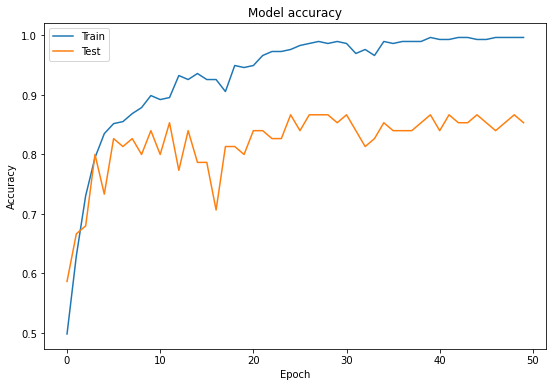

In [131]:
# Plot training & validation accuracy values
plt.figure(figsize=(9,6))
plt.plot(RNN_history.history['accuracy'])
plt.plot(RNN_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

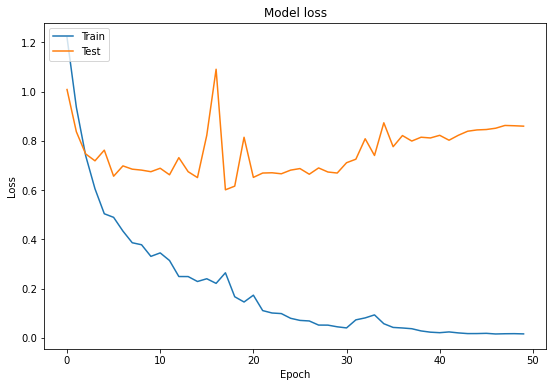

In [132]:
# Plot training & validation loss values
plt.figure(figsize=(9,6))
plt.plot(RNN_history.history['loss'])
plt.plot(RNN_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [124]:
y_pred_RNN = RNN_model.predict(feature_test)

3/3 [==============================] - 1s 18ms/step


In [125]:
y_pred_RNN_class = np.argmax(y_pred_RNN, axis=1)
y_pred_RNN_class

array([2, 2, 2, 1, 1, 2, 2, 0, 1, 1, 2, 2, 1, 0, 2, 1, 1, 2, 2, 1, 0, 0,
       0, 1, 0, 1, 0, 2, 1, 2, 0, 2, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 2,
       1, 0, 1, 2, 2, 2, 0, 0, 1, 1, 1, 2, 0, 1, 2, 1, 1, 2, 1, 2, 1, 2,
       0, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 2, 1, 2, 1, 1, 1, 1, 2, 0,
       1, 2, 1, 1, 1])

In [126]:
accuracy_score(y_test_class, y_pred_RNN_class)

0.8602150537634409

In [127]:
print(classification_report(y_test_class, y_pred_RNN_class))

              precision    recall  f1-score   support

           0       0.70      0.74      0.72        19
           1       0.98      0.90      0.94        50
           2       0.78      0.91      0.84        23
           3       0.00      0.00      0.00         1

    accuracy                           0.86        93
   macro avg       0.61      0.64      0.62        93
weighted avg       0.86      0.86      0.86        93



/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Parameters tuning for LSTM 

In [64]:
def objective_func2(optimizer_index, activation_index, learning_rate, epoch, batch_size):

    optimizers_dict = {'SGD':SGD(lr=learning_rate), 'RMSprop':RMSprop(lr=learning_rate), 'Adam':Adam(lr=learning_rate), 'Adagrad':Adagrad(lr=learning_rate)}

    optimizer = optimizers_dict[optimizers_list[round(optimizer_index)]]
    activation = activations_list[round(activation_index)]

    def create_RNN_model():
        RNN = Sequential()
        RNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=False))

        RNN.add(Bidirectional(LSTM(word_dimension)))
        RNN.add(Dense(word_dimension, activation=activation))
        RNN.add(Dense(4, activation='sigmoid'))
        RNN.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        #RNN.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
    
        return RNN
    
    RNN_model = create_RNN_model()

    RNN_model.fit(feature_train, y_train, epochs=round(epoch), batch_size=round(batch_size), validation_data=(feature_val, y_val))

    y_pred_RNN = RNN_model.predict(feature_test)
    y_pred_RNN_class = np.argmax(y_pred_RNN, axis=1)
        
    return accuracy_score(y_test_class, y_pred_RNN_class)

In [65]:
params_rnn ={
    'optimizer_index':(0,3),
    'activation_index':(0, 3),
    'learning_rate':learning_rates,
    'epoch':epochs,
    'batch_size':batch_sizes
    
}

nn_bo = BayesianOptimization(objective_func1, params_rnn, random_state=110)
nn_bo.maximize(init_points=25, n_iter=3)

|   iter    |  target   | activa... | batch_... |   epoch   | learni... | optimi... |
-------------------------------------------------------------------------------------


/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50
3/3 [==============================] - 1s 161ms/step - loss: 219597.8125 - accuracy: 0.3805 - val_loss: 776.2170 - val_accuracy: 0.2800
Epoch 2/50
3/3 [==============================] - 0s 32ms/step - loss: 603.6285 - accuracy: 0.2997 - val_loss: 913.0525 - val_accuracy: 0.5733
Epoch 3/50
3/3 [==============================] - 0s 35ms/step - loss: 171.2936 - accuracy: 0.4848 - val_loss: 209.2118 - val_accuracy: 0.0933
Epoch 4/50
3/3 [==============================] - 0s 38ms/step - loss: 158.9744 - accuracy: 0.3973 - val_loss: 14.0238 - val_accuracy: 0.6000
Epoch 5/50
3/3 [==============================] - 0s 41ms/step - loss: 205.3590 - accuracy: 0.4074 - val_loss: 134.6695 - val_accuracy: 0.2400
Epoch 6/50
3/3 [==============================] - 0s 55ms/step - loss: 291.7925 - accuracy: 0.3300 - val_loss: 507.3029 - val_accuracy: 0.2400
Epoch 7/50
3/3 [==============================] - 0s 30ms/step - loss: 264.9625 - accuracy: 0.4377 - val_loss: 1020.1664 - val_accuracy: 0.

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3/3 [==============================] - 1s 147ms/step - loss: 1.8987 - accuracy: 0.2828 - val_loss: 8.4880 - val_accuracy: 0.1600
Epoch 2/71
3/3 [==============================] - 0s 30ms/step - loss: 7.4467 - accuracy: 0.3535 - val_loss: 12.0312 - val_accuracy: 0.1333
Epoch 3/71
3/3 [==============================] - 0s 48ms/step - loss: 11.3572 - accuracy: 0.3266 - val_loss: 13.0117 - val_accuracy: 0.5867
Epoch 4/71
3/3 [==============================] - 0s 114ms/step - loss: 16.3560 - accuracy: 0.4714 - val_loss: 20.8721 - val_accuracy: 0.1600
Epoch 5/71
3/3 [==============================] - 0s 61ms/step - loss: 16.2803 - accuracy: 0.3468 - val_loss: 19.5635 - val_accuracy: 0.5867
Epoch 6/71
3/3 [==============================] - 0s 62ms/step - loss: 14.5232 - accuracy: 0.3704 - val_loss: 29.8827 - val_accuracy: 0.2400
Epoch 7/71
3/3 [==============================] - 0s 49ms/step - loss: 21.4665 - accuracy: 0.4040 - val_loss: 13.3676 - val_accuracy: 0.2800
Epoch 8/71
3/3 [=========

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


7/7 [==============================] - 1s 36ms/step - loss: 65.2860 - accuracy: 0.3199 - val_loss: 4.7329 - val_accuracy: 0.5867
Epoch 2/31
7/7 [==============================] - 0s 13ms/step - loss: 13.2930 - accuracy: 0.3670 - val_loss: 5.2564 - val_accuracy: 0.5867
Epoch 3/31
7/7 [==============================] - 0s 16ms/step - loss: 3.0307 - accuracy: 0.4411 - val_loss: 2.3202 - val_accuracy: 0.5867
Epoch 4/31
7/7 [==============================] - 0s 44ms/step - loss: 1.6792 - accuracy: 0.4242 - val_loss: 1.5066 - val_accuracy: 0.5867
Epoch 5/31
7/7 [==============================] - 0s 33ms/step - loss: 1.4653 - accuracy: 0.4512 - val_loss: 2.2239 - val_accuracy: 0.2533
Epoch 6/31
7/7 [==============================] - 0s 48ms/step - loss: 1.7340 - accuracy: 0.3838 - val_loss: 1.9139 - val_accuracy: 0.2400
Epoch 7/31
7/7 [==============================] - 0s 29ms/step - loss: 1.4819 - accuracy: 0.4310 - val_loss: 0.9574 - val_accuracy: 0.6000
Epoch 8/31
7/7 [====================

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


38/38 [==============================] - 1s 8ms/step - loss: 1373.4286 - accuracy: 0.4040 - val_loss: 6.1245 - val_accuracy: 0.4267
Epoch 2/65
38/38 [==============================] - 0s 5ms/step - loss: 8.3308 - accuracy: 0.3771 - val_loss: 4.3941 - val_accuracy: 0.2400
Epoch 3/65
38/38 [==============================] - 0s 7ms/step - loss: 4.3561 - accuracy: 0.4007 - val_loss: 7.0632 - val_accuracy: 0.1600
Epoch 4/65
38/38 [==============================] - 0s 6ms/step - loss: 19.9585 - accuracy: 0.3434 - val_loss: 7.6335 - val_accuracy: 0.5867
Epoch 5/65
38/38 [==============================] - 0s 6ms/step - loss: 7.1041 - accuracy: 0.4040 - val_loss: 13.3316 - val_accuracy: 0.2400
Epoch 6/65
38/38 [==============================] - 0s 10ms/step - loss: 181.3262 - accuracy: 0.4108 - val_loss: 58.3159 - val_accuracy: 0.5600
Epoch 7/65
38/38 [==============================] - 0s 10ms/step - loss: 24.2035 - accuracy: 0.3468 - val_loss: 3.0447 - val_accuracy: 0.5867
Epoch 8/65
38/38 [==

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3/3 [==============================] - 1s 162ms/step - loss: 2674884.0000 - accuracy: 0.2256 - val_loss: 27343916.0000 - val_accuracy: 0.0133
Epoch 2/68
3/3 [==============================] - 0s 45ms/step - loss: 22949950.0000 - accuracy: 0.2862 - val_loss: 306049.7812 - val_accuracy: 0.5600
Epoch 3/68
3/3 [==============================] - 0s 69ms/step - loss: 187596.7969 - accuracy: 0.4545 - val_loss: 8611.2754 - val_accuracy: 0.4800
Epoch 4/68
3/3 [==============================] - 0s 64ms/step - loss: 13643.5615 - accuracy: 0.4310 - val_loss: 2262.4470 - val_accuracy: 0.3733
Epoch 5/68
3/3 [==============================] - 0s 48ms/step - loss: 4102.5537 - accuracy: 0.4815 - val_loss: 3403.1526 - val_accuracy: 0.3600
Epoch 6/68
3/3 [==============================] - 0s 68ms/step - loss: 1754.4897 - accuracy: 0.5354 - val_loss: 659.5407 - val_accuracy: 0.3600
Epoch 7/68
3/3 [==============================] - 0s 79ms/step - loss: 2070.8728 - accuracy: 0.4848 - val_loss: 1881.9315 - v

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


17/17 [==============================] - 1s 16ms/step - loss: 851074.1875 - accuracy: 0.3603 - val_loss: 98.6777 - val_accuracy: 0.2267
Epoch 2/88
17/17 [==============================] - 0s 6ms/step - loss: 2.1404 - accuracy: 0.4680 - val_loss: 95.1300 - val_accuracy: 0.2000
Epoch 3/88
17/17 [==============================] - 0s 6ms/step - loss: 1.0834 - accuracy: 0.5017 - val_loss: 94.8512 - val_accuracy: 0.6000
Epoch 4/88
17/17 [==============================] - 0s 10ms/step - loss: 1.0947 - accuracy: 0.4916 - val_loss: 94.8672 - val_accuracy: 0.6000
Epoch 5/88
17/17 [==============================] - 0s 14ms/step - loss: 1.1017 - accuracy: 0.4714 - val_loss: 94.7992 - val_accuracy: 0.6000
Epoch 6/88
17/17 [==============================] - 0s 10ms/step - loss: 1.0952 - accuracy: 0.5118 - val_loss: 94.9377 - val_accuracy: 0.6000
Epoch 7/88
17/17 [==============================] - 0s 8ms/step - loss: 1.0931 - accuracy: 0.5051 - val_loss: 95.2245 - val_accuracy: 0.2400
Epoch 8/88
17/1

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


4/4 [==============================] - 4s 1s/step - loss: 101.4022 - accuracy: 0.2155 - val_loss: 26.3152 - val_accuracy: 0.5867
Epoch 2/51
4/4 [==============================] - 0s 35ms/step - loss: 67.2478 - accuracy: 0.3872 - val_loss: 65.9524 - val_accuracy: 0.5867
Epoch 3/51
4/4 [==============================] - 0s 24ms/step - loss: 66.0385 - accuracy: 0.4747 - val_loss: 66.6456 - val_accuracy: 0.2400
Epoch 4/51
4/4 [==============================] - 0s 20ms/step - loss: 84.4293 - accuracy: 0.3098 - val_loss: 80.5177 - val_accuracy: 0.2400
Epoch 5/51
4/4 [==============================] - 0s 19ms/step - loss: 47.5737 - accuracy: 0.4343 - val_loss: 56.7403 - val_accuracy: 0.2400
Epoch 6/51
4/4 [==============================] - 0s 20ms/step - loss: 50.3396 - accuracy: 0.3704 - val_loss: 50.7875 - val_accuracy: 0.5867
Epoch 7/51
4/4 [==============================] - 0s 21ms/step - loss: 52.7977 - accuracy: 0.4141 - val_loss: 51.1975 - val_accuracy: 0.5867
Epoch 8/51
4/4 [=========

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


27/27 [==============================] - 1s 9ms/step - loss: 17.4261 - accuracy: 0.3973 - val_loss: 17.7321 - val_accuracy: 0.5867
Epoch 2/68
27/27 [==============================] - 0s 4ms/step - loss: 16.8582 - accuracy: 0.4242 - val_loss: 18.6145 - val_accuracy: 0.2400
Epoch 3/68
27/27 [==============================] - 0s 4ms/step - loss: 17.6299 - accuracy: 0.3906 - val_loss: 23.8161 - val_accuracy: 0.2400
Epoch 4/68
27/27 [==============================] - 0s 4ms/step - loss: 18.4205 - accuracy: 0.3468 - val_loss: 21.4338 - val_accuracy: 0.2400
Epoch 5/68
27/27 [==============================] - 0s 4ms/step - loss: 19.0657 - accuracy: 0.3434 - val_loss: 10.8953 - val_accuracy: 0.5867
Epoch 6/68
27/27 [==============================] - 0s 5ms/step - loss: 15.3829 - accuracy: 0.3939 - val_loss: 12.6978 - val_accuracy: 0.2533
Epoch 7/68
27/27 [==============================] - 0s 5ms/step - loss: 16.1060 - accuracy: 0.4209 - val_loss: 6.7823 - val_accuracy: 0.5867
Epoch 8/68
27/27 [

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3/3 [==============================] - 1s 110ms/step - loss: 96598088.0000 - accuracy: 0.1852 - val_loss: 225895088.0000 - val_accuracy: 0.2267
Epoch 2/83
3/3 [==============================] - 0s 39ms/step - loss: 129450536.0000 - accuracy: 0.4882 - val_loss: 685267.6875 - val_accuracy: 0.5200
Epoch 3/83
3/3 [==============================] - 0s 57ms/step - loss: 483377.1250 - accuracy: 0.3838 - val_loss: 29203.8965 - val_accuracy: 0.5867
Epoch 4/83
3/3 [==============================] - 0s 70ms/step - loss: 22387.8809 - accuracy: 0.4175 - val_loss: 1193.8579 - val_accuracy: 0.5867
Epoch 5/83
3/3 [==============================] - 0s 50ms/step - loss: 7446.9150 - accuracy: 0.3704 - val_loss: 2412.8560 - val_accuracy: 0.5867
Epoch 6/83
3/3 [==============================] - 0s 54ms/step - loss: 5938.2617 - accuracy: 0.3165 - val_loss: 1257.7762 - val_accuracy: 0.1733
Epoch 7/83
3/3 [==============================] - 0s 46ms/step - loss: 4034.4604 - accuracy: 0.3569 - val_loss: 3720.319

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3/3 [==============================] - 0s 85ms/step - loss: 539.0833 - accuracy: 0.3199 - val_loss: 1.0771 - val_accuracy: 0.5867
Epoch 2/35
3/3 [==============================] - 0s 22ms/step - loss: 1.1225 - accuracy: 0.4714 - val_loss: 1.0692 - val_accuracy: 0.5867
Epoch 3/35
3/3 [==============================] - 0s 29ms/step - loss: 1.1194 - accuracy: 0.4983 - val_loss: 1.0494 - val_accuracy: 0.5867
Epoch 4/35
3/3 [==============================] - 0s 26ms/step - loss: 1.0643 - accuracy: 0.5152 - val_loss: 1.0193 - val_accuracy: 0.5867
Epoch 5/35
3/3 [==============================] - 0s 29ms/step - loss: 1.0678 - accuracy: 0.5152 - val_loss: 1.0649 - val_accuracy: 0.5867
Epoch 6/35
3/3 [==============================] - 0s 35ms/step - loss: 1.0677 - accuracy: 0.5152 - val_loss: 1.0259 - val_accuracy: 0.5867
Epoch 7/35
3/3 [==============================] - 0s 36ms/step - loss: 1.0633 - accuracy: 0.5152 - val_loss: 1.0227 - val_accuracy: 0.5867
Epoch 8/35
3/3 [====================

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3/3 [==============================] - 0s 80ms/step - loss: 4117.7710 - accuracy: 0.2828 - val_loss: 1.7697 - val_accuracy: 0.2000
Epoch 2/91
3/3 [==============================] - 0s 21ms/step - loss: 1.9633 - accuracy: 0.3805 - val_loss: 1.1328 - val_accuracy: 0.2400
Epoch 3/91
3/3 [==============================] - 0s 21ms/step - loss: 1.3903 - accuracy: 0.4781 - val_loss: 1.0493 - val_accuracy: 0.5867
Epoch 4/91
3/3 [==============================] - 0s 21ms/step - loss: 1.0487 - accuracy: 0.5286 - val_loss: 1.0321 - val_accuracy: 0.5867
Epoch 5/91
3/3 [==============================] - 0s 20ms/step - loss: 1.0505 - accuracy: 0.5286 - val_loss: 1.0399 - val_accuracy: 0.5867
Epoch 6/91
3/3 [==============================] - 0s 22ms/step - loss: 1.0398 - accuracy: 0.5320 - val_loss: 1.0191 - val_accuracy: 0.5867
Epoch 7/91
3/3 [==============================] - 0s 23ms/step - loss: 1.0371 - accuracy: 0.5320 - val_loss: 1.0108 - val_accuracy: 0.5867
Epoch 8/91
3/3 [===================

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3/3 [==============================] - 1s 88ms/step - loss: 145.9163 - accuracy: 0.3502 - val_loss: 22426.6973 - val_accuracy: 0.5867
Epoch 2/59
3/3 [==============================] - 0s 25ms/step - loss: 106336.8047 - accuracy: 0.3906 - val_loss: 10109.4990 - val_accuracy: 0.1600
Epoch 3/59
3/3 [==============================] - 0s 27ms/step - loss: 7898.1602 - accuracy: 0.4108 - val_loss: 8570.7197 - val_accuracy: 0.2400
Epoch 4/59
3/3 [==============================] - 0s 30ms/step - loss: 6060.5200 - accuracy: 0.3737 - val_loss: 1381.8862 - val_accuracy: 0.2667
Epoch 5/59
3/3 [==============================] - 0s 47ms/step - loss: 970.3765 - accuracy: 0.3468 - val_loss: 79.9377 - val_accuracy: 0.6000
Epoch 6/59
3/3 [==============================] - 0s 70ms/step - loss: 172.7393 - accuracy: 0.4040 - val_loss: 70.5690 - val_accuracy: 0.6000
Epoch 7/59
3/3 [==============================] - 0s 60ms/step - loss: 99.1459 - accuracy: 0.4646 - val_loss: 38.9030 - val_accuracy: 0.2400
Epo

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3/3 [==============================] - 1s 92ms/step - loss: 82.7029 - accuracy: 0.1953 - val_loss: 104.0866 - val_accuracy: 0.5867
Epoch 2/52
3/3 [==============================] - 0s 25ms/step - loss: 148.6683 - accuracy: 0.4579 - val_loss: 93.9974 - val_accuracy: 0.2400
Epoch 3/52
3/3 [==============================] - 0s 34ms/step - loss: 93.8083 - accuracy: 0.3232 - val_loss: 67.8945 - val_accuracy: 0.5867
Epoch 4/52
3/3 [==============================] - 0s 56ms/step - loss: 110.2359 - accuracy: 0.4242 - val_loss: 36.2323 - val_accuracy: 0.2400
Epoch 5/52
3/3 [==============================] - 0s 135ms/step - loss: 61.8734 - accuracy: 0.3367 - val_loss: 69.7944 - val_accuracy: 0.5867
Epoch 6/52
3/3 [==============================] - 0s 53ms/step - loss: 86.5479 - accuracy: 0.4040 - val_loss: 71.7562 - val_accuracy: 0.1600
Epoch 7/52
3/3 [==============================] - 0s 60ms/step - loss: 55.1427 - accuracy: 0.3098 - val_loss: 68.4348 - val_accuracy: 0.5867
Epoch 8/52
3/3 [====

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


4/4 [==============================] - 1s 86ms/step - loss: 61210880.0000 - accuracy: 0.3098 - val_loss: 523.1671 - val_accuracy: 0.5867
Epoch 2/34
4/4 [==============================] - 0s 20ms/step - loss: 411.3868 - accuracy: 0.3939 - val_loss: 512.3804 - val_accuracy: 0.2400
Epoch 3/34
4/4 [==============================] - 0s 24ms/step - loss: 11.5205 - accuracy: 0.3300 - val_loss: 499.6380 - val_accuracy: 0.5733
Epoch 4/34
4/4 [==============================] - 0s 31ms/step - loss: 2.8486 - accuracy: 0.4579 - val_loss: 503.8954 - val_accuracy: 0.1600
Epoch 5/34
4/4 [==============================] - 0s 37ms/step - loss: 1.1138 - accuracy: 0.4007 - val_loss: 503.7284 - val_accuracy: 0.5733
Epoch 6/34
4/4 [==============================] - 0s 32ms/step - loss: 1.1569 - accuracy: 0.4108 - val_loss: 504.5439 - val_accuracy: 0.2400
Epoch 7/34
4/4 [==============================] - 0s 47ms/step - loss: 1.2979 - accuracy: 0.4444 - val_loss: 504.0312 - val_accuracy: 0.2400
Epoch 8/34
4/4

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


4/4 [==============================] - 1s 60ms/step - loss: 98.8690 - accuracy: 0.3603 - val_loss: 1.3139 - val_accuracy: 0.5733
Epoch 2/88
4/4 [==============================] - 0s 20ms/step - loss: 1.2787 - accuracy: 0.4983 - val_loss: 1.0900 - val_accuracy: 0.6000
Epoch 3/88
4/4 [==============================] - 0s 20ms/step - loss: 1.1583 - accuracy: 0.4444 - val_loss: 1.0272 - val_accuracy: 0.5867
Epoch 4/88
4/4 [==============================] - 0s 27ms/step - loss: 1.0755 - accuracy: 0.4613 - val_loss: 1.0100 - val_accuracy: 0.6000
Epoch 5/88
4/4 [==============================] - 0s 51ms/step - loss: 1.0229 - accuracy: 0.5354 - val_loss: 1.0041 - val_accuracy: 0.6000
Epoch 6/88
4/4 [==============================] - 0s 67ms/step - loss: 1.0339 - accuracy: 0.5354 - val_loss: 1.0018 - val_accuracy: 0.6000
Epoch 7/88
4/4 [==============================] - 0s 42ms/step - loss: 1.0044 - accuracy: 0.5354 - val_loss: 1.0085 - val_accuracy: 0.6000
Epoch 8/88
4/4 [=====================

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


25/25 [==============================] - 1s 14ms/step - loss: 30.9305 - accuracy: 0.3805 - val_loss: 20.9725 - val_accuracy: 0.5867
Epoch 2/77
25/25 [==============================] - 0s 9ms/step - loss: 41.4559 - accuracy: 0.3199 - val_loss: 41.5883 - val_accuracy: 0.5867
Epoch 3/77
25/25 [==============================] - 0s 13ms/step - loss: 29.1204 - accuracy: 0.4108 - val_loss: 47.4735 - val_accuracy: 0.5867
Epoch 4/77
25/25 [==============================] - 0s 7ms/step - loss: 34.0982 - accuracy: 0.3771 - val_loss: 29.5855 - val_accuracy: 0.5867
Epoch 5/77
25/25 [==============================] - 0s 17ms/step - loss: 29.4349 - accuracy: 0.3838 - val_loss: 35.3283 - val_accuracy: 0.5867
Epoch 6/77
25/25 [==============================] - 0s 9ms/step - loss: 34.6793 - accuracy: 0.3838 - val_loss: 40.0783 - val_accuracy: 0.5867
Epoch 7/77
25/25 [==============================] - 0s 6ms/step - loss: 27.2591 - accuracy: 0.4545 - val_loss: 18.7861 - val_accuracy: 0.5867
Epoch 8/77
25/

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2/2 [==============================] - 1s 193ms/step - loss: 32524406.0000 - accuracy: 0.1785 - val_loss: 21939640.0000 - val_accuracy: 0.2400
Epoch 2/81
2/2 [==============================] - 0s 85ms/step - loss: 96735384.0000 - accuracy: 0.2121 - val_loss: 2520965.0000 - val_accuracy: 0.1733
Epoch 3/81
2/2 [==============================] - 0s 298ms/step - loss: 3066989.0000 - accuracy: 0.3535 - val_loss: 573139.6875 - val_accuracy: 0.2400
Epoch 4/81
2/2 [==============================] - 0s 181ms/step - loss: 835718.5625 - accuracy: 0.3603 - val_loss: 216442.1875 - val_accuracy: 0.5067
Epoch 5/81
2/2 [==============================] - 0s 127ms/step - loss: 252332.6406 - accuracy: 0.4175 - val_loss: 74533.8906 - val_accuracy: 0.5867
Epoch 6/81
2/2 [==============================] - 0s 118ms/step - loss: 66843.7188 - accuracy: 0.4983 - val_loss: 7999.6333 - val_accuracy: 0.5600
Epoch 7/81
2/2 [==============================] - 0s 112ms/step - loss: 14484.3906 - accuracy: 0.4545 - val_

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


5/5 [==============================] - 1s 50ms/step - loss: 4367.6943 - accuracy: 0.3064 - val_loss: 3312.1038 - val_accuracy: 0.5867
Epoch 2/58
5/5 [==============================] - 0s 16ms/step - loss: 1217.3595 - accuracy: 0.3165 - val_loss: 49.5681 - val_accuracy: 0.5867
Epoch 3/58
5/5 [==============================] - 0s 18ms/step - loss: 34.9852 - accuracy: 0.3771 - val_loss: 5.6418 - val_accuracy: 0.5867
Epoch 4/58
5/5 [==============================] - 0s 23ms/step - loss: 7.2183 - accuracy: 0.4242 - val_loss: 1.4742 - val_accuracy: 0.5867
Epoch 5/58
5/5 [==============================] - 0s 37ms/step - loss: 2.4679 - accuracy: 0.4108 - val_loss: 1.3022 - val_accuracy: 0.4000
Epoch 6/58
5/5 [==============================] - 0s 39ms/step - loss: 2.5993 - accuracy: 0.4074 - val_loss: 1.3525 - val_accuracy: 0.5467
Epoch 7/58
5/5 [==============================] - 0s 51ms/step - loss: 2.2069 - accuracy: 0.4141 - val_loss: 1.1372 - val_accuracy: 0.6000
Epoch 8/58
5/5 [===========

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 3s 42ms/step - loss: 2.4765 - accuracy: 0.3906 - val_loss: 1.4874 - val_accuracy: 0.5867
Epoch 2/32
8/8 [==============================] - 0s 16ms/step - loss: 2.6690 - accuracy: 0.3906 - val_loss: 4.0159 - val_accuracy: 0.2400
Epoch 3/32
8/8 [==============================] - 0s 31ms/step - loss: 2.1319 - accuracy: 0.3838 - val_loss: 1.2512 - val_accuracy: 0.5467
Epoch 4/32
8/8 [==============================] - 0s 24ms/step - loss: 1.3576 - accuracy: 0.4276 - val_loss: 1.0111 - val_accuracy: 0.6533
Epoch 5/32
8/8 [==============================] - 0s 22ms/step - loss: 1.0403 - accuracy: 0.4949 - val_loss: 0.8993 - val_accuracy: 0.5867
Epoch 6/32
8/8 [==============================] - 0s 25ms/step - loss: 0.8838 - accuracy: 0.5960 - val_loss: 1.1279 - val_accuracy: 0.3333
Epoch 7/32
8/8 [==============================] - 0s 30ms/step - loss: 1.8576 - accuracy: 0.4141 - val_loss: 1.2533 - val_accuracy: 0.5867
Epoch 8/32
8/8 [======================

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/21
3/3 [==============================] - 1s 104ms/step - loss: 21.8026 - accuracy: 0.2121 - val_loss: 43.7641 - val_accuracy: 0.2400
Epoch 2/21
3/3 [==============================] - 0s 32ms/step - loss: 46.7248 - accuracy: 0.3333 - val_loss: 42.9986 - val_accuracy: 0.2400
Epoch 3/21
3/3 [==============================] - 0s 39ms/step - loss: 45.5703 - accuracy: 0.3300 - val_loss: 10.2116 - val_accuracy: 0.2400
Epoch 4/21
3/3 [==============================] - 0s 69ms/step - loss: 28.3934 - accuracy: 0.3805 - val_loss: 27.2180 - val_accuracy: 0.5867
Epoch 5/21
3/3 [==============================] - 0s 74ms/step - loss: 38.3197 - accuracy: 0.4141 - val_loss: 11.6930 - val_accuracy: 0.1600
Epoch 6/21
3/3 [==============================] - 0s 91ms/step - loss: 23.2463 - accuracy: 0.3737 - val_loss: 29.0431 - val_accuracy: 0.2400
Epoch 7/21
3/3 [==============================] - 0s 78ms/step - loss: 28.2239 - accuracy: 0.3737 - val_loss: 32.2414 - val_accuracy: 0.5867
Epoch 8/21
3

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3/3 [==============================] - 1s 89ms/step - loss: 21.6409 - accuracy: 0.2088 - val_loss: 76.9496 - val_accuracy: 0.1600
Epoch 2/51
3/3 [==============================] - 0s 22ms/step - loss: 127.4009 - accuracy: 0.3569 - val_loss: 95.0955 - val_accuracy: 0.5867
Epoch 3/51
3/3 [==============================] - 0s 27ms/step - loss: 91.0929 - accuracy: 0.4579 - val_loss: 48.6155 - val_accuracy: 0.2800
Epoch 4/51
3/3 [==============================] - 0s 28ms/step - loss: 60.6456 - accuracy: 0.3771 - val_loss: 40.1606 - val_accuracy: 0.5867
Epoch 5/51
3/3 [==============================] - 0s 32ms/step - loss: 53.8395 - accuracy: 0.3098 - val_loss: 57.5164 - val_accuracy: 0.2800
Epoch 6/51
3/3 [==============================] - 0s 75ms/step - loss: 60.3898 - accuracy: 0.3838 - val_loss: 36.6756 - val_accuracy: 0.5867
Epoch 7/51
3/3 [==============================] - 0s 109ms/step - loss: 43.9520 - accuracy: 0.3704 - val_loss: 52.7337 - val_accuracy: 0.2400
Epoch 8/51
3/3 [======

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3/3 [==============================] - 1s 164ms/step - loss: 9.2571 - accuracy: 0.2761 - val_loss: 65.7442 - val_accuracy: 0.1600
Epoch 2/22
3/3 [==============================] - 0s 33ms/step - loss: 46.4531 - accuracy: 0.3502 - val_loss: 49.0301 - val_accuracy: 0.2400
Epoch 3/22
3/3 [==============================] - 0s 39ms/step - loss: 41.3655 - accuracy: 0.3401 - val_loss: 25.0673 - val_accuracy: 0.5867
Epoch 4/22
3/3 [==============================] - 0s 46ms/step - loss: 21.7583 - accuracy: 0.4949 - val_loss: 23.0524 - val_accuracy: 0.1600
Epoch 5/22
3/3 [==============================] - 0s 52ms/step - loss: 27.2776 - accuracy: 0.2525 - val_loss: 17.8525 - val_accuracy: 0.5867
Epoch 6/22
3/3 [==============================] - 0s 73ms/step - loss: 21.2857 - accuracy: 0.5118 - val_loss: 12.9720 - val_accuracy: 0.5867
Epoch 7/22
3/3 [==============================] - 0s 61ms/step - loss: 17.4052 - accuracy: 0.3771 - val_loss: 14.3943 - val_accuracy: 0.1600
Epoch 8/22
3/3 [========

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3/3 [==============================] - 1s 100ms/step - loss: 191236.2344 - accuracy: 0.1818 - val_loss: 6236295.5000 - val_accuracy: 0.1600
Epoch 2/38
3/3 [==============================] - 0s 31ms/step - loss: 2973228.5000 - accuracy: 0.3670 - val_loss: 67458.9297 - val_accuracy: 0.5867
Epoch 3/38
3/3 [==============================] - 0s 58ms/step - loss: 90796.4141 - accuracy: 0.4983 - val_loss: 115861.8438 - val_accuracy: 0.2400
Epoch 4/38
3/3 [==============================] - 0s 115ms/step - loss: 96882.4141 - accuracy: 0.3401 - val_loss: 35739.7227 - val_accuracy: 0.4000
Epoch 5/38
3/3 [==============================] - 0s 74ms/step - loss: 31504.4180 - accuracy: 0.3838 - val_loss: 4147.0640 - val_accuracy: 0.5600
Epoch 6/38
3/3 [==============================] - 0s 55ms/step - loss: 6855.3823 - accuracy: 0.4714 - val_loss: 1923.3275 - val_accuracy: 0.5333
Epoch 7/38
3/3 [==============================] - 0s 63ms/step - loss: 5739.5522 - accuracy: 0.3165 - val_loss: 2465.7073 - 

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3/3 [==============================] - 1s 99ms/step - loss: 3.0974 - accuracy: 0.2391 - val_loss: 5.1398 - val_accuracy: 0.1733
Epoch 2/75
3/3 [==============================] - 0s 34ms/step - loss: 5.3509 - accuracy: 0.4209 - val_loss: 3.1112 - val_accuracy: 0.5867
Epoch 3/75
3/3 [==============================] - 0s 85ms/step - loss: 4.0196 - accuracy: 0.3939 - val_loss: 1.3906 - val_accuracy: 0.2400
Epoch 4/75
3/3 [==============================] - 0s 116ms/step - loss: 3.1073 - accuracy: 0.4074 - val_loss: 2.8090 - val_accuracy: 0.5867
Epoch 5/75
3/3 [==============================] - 0s 95ms/step - loss: 3.2701 - accuracy: 0.4646 - val_loss: 1.6413 - val_accuracy: 0.3867
Epoch 6/75
3/3 [==============================] - 0s 73ms/step - loss: 2.3265 - accuracy: 0.3771 - val_loss: 1.3596 - val_accuracy: 0.6000
Epoch 7/75
3/3 [==============================] - 0s 59ms/step - loss: 2.2941 - accuracy: 0.4478 - val_loss: 1.6417 - val_accuracy: 0.4267
Epoch 8/75
3/3 [=====================

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


7/7 [==============================] - 1s 52ms/step - loss: 541685363568981961189356591537717248.0000 - accuracy: 0.3468 - val_loss: nan - val_accuracy: 0.5867
Epoch 2/70
7/7 [==============================] - 0s 49ms/step - loss: nan - accuracy: 0.2054 - val_loss: nan - val_accuracy: 0.1600
Epoch 3/70
7/7 [==============================] - 0s 30ms/step - loss: nan - accuracy: 0.1785 - val_loss: nan - val_accuracy: 0.1600
Epoch 4/70
7/7 [==============================] - 0s 22ms/step - loss: nan - accuracy: 0.1785 - val_loss: nan - val_accuracy: 0.1600
Epoch 5/70
7/7 [==============================] - 0s 22ms/step - loss: nan - accuracy: 0.1785 - val_loss: nan - val_accuracy: 0.1600
Epoch 6/70
7/7 [==============================] - 0s 20ms/step - loss: nan - accuracy: 0.1785 - val_loss: nan - val_accuracy: 0.1600
Epoch 7/70
7/7 [==============================] - 0s 19ms/step - loss: nan - accuracy: 0.1785 - val_loss: nan - val_accuracy: 0.1600
Epoch 8/70
7/7 [==========================

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


4/4 [==============================] - 1s 66ms/step - loss: 49496.8164 - accuracy: 0.3300 - val_loss: 62.1040 - val_accuracy: 0.5467
Epoch 2/79
4/4 [==============================] - 0s 24ms/step - loss: 45.1103 - accuracy: 0.3603 - val_loss: 8.4351 - val_accuracy: 0.5733
Epoch 3/79
4/4 [==============================] - 0s 24ms/step - loss: 17.2561 - accuracy: 0.3704 - val_loss: 3.5352 - val_accuracy: 0.5733
Epoch 4/79
4/4 [==============================] - 0s 30ms/step - loss: 5.5494 - accuracy: 0.4444 - val_loss: 7.8833 - val_accuracy: 0.5867
Epoch 5/79
4/4 [==============================] - 0s 37ms/step - loss: 8.4505 - accuracy: 0.5051 - val_loss: 17.0673 - val_accuracy: 0.5867
Epoch 6/79
4/4 [==============================] - 0s 46ms/step - loss: 15.4457 - accuracy: 0.5185 - val_loss: 121.5689 - val_accuracy: 0.5733
Epoch 7/79
4/4 [==============================] - 0s 33ms/step - loss: 2.1113 - accuracy: 0.4276 - val_loss: 172.6885 - val_accuracy: 0.5733
Epoch 8/79
4/4 [=========

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


4/4 [==============================] - 1s 69ms/step - loss: 8.5058 - accuracy: 0.4343 - val_loss: 1.2427 - val_accuracy: 0.5867
Epoch 2/59
4/4 [==============================] - 0s 23ms/step - loss: 1.3480 - accuracy: 0.4512 - val_loss: 1.1734 - val_accuracy: 0.2533
Epoch 3/59
4/4 [==============================] - 0s 24ms/step - loss: 1.1691 - accuracy: 0.4242 - val_loss: 1.0602 - val_accuracy: 0.5867
Epoch 4/59
4/4 [==============================] - 0s 30ms/step - loss: 1.1956 - accuracy: 0.5185 - val_loss: 1.0511 - val_accuracy: 0.5867
Epoch 5/59
4/4 [==============================] - 0s 59ms/step - loss: 1.1782 - accuracy: 0.4310 - val_loss: 1.0738 - val_accuracy: 0.4667
Epoch 6/59
4/4 [==============================] - 0s 48ms/step - loss: 1.0083 - accuracy: 0.4714 - val_loss: 0.9364 - val_accuracy: 0.5867
Epoch 7/59
4/4 [==============================] - 0s 46ms/step - loss: 1.0150 - accuracy: 0.5825 - val_loss: 0.8683 - val_accuracy: 0.6667
Epoch 8/59
4/4 [======================

/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/94
3/3 [==============================] - 1s 249ms/step - loss: 2.1721 - accuracy: 0.4411 - val_loss: 14.1664 - val_accuracy: 0.5867
Epoch 2/94
3/3 [==============================] - 0s 83ms/step - loss: 21.5822 - accuracy: 0.3704 - val_loss: 4.0482 - val_accuracy: 0.5200
Epoch 3/94
3/3 [==============================] - 0s 64ms/step - loss: 7.7694 - accuracy: 0.3771 - val_loss: 6.8873 - val_accuracy: 0.2667
Epoch 4/94
3/3 [==============================] - 0s 58ms/step - loss: 8.3523 - accuracy: 0.4175 - val_loss: 6.7256 - val_accuracy: 0.2400
Epoch 5/94
3/3 [==============================] - 0s 58ms/step - loss: 8.3607 - accuracy: 0.4377 - val_loss: 5.8153 - val_accuracy: 0.5867
Epoch 6/94
3/3 [==============================] - 0s 50ms/step - loss: 5.2734 - accuracy: 0.4411 - val_loss: 5.5563 - val_accuracy: 0.2267
Epoch 7/94
3/3 [==============================] - 0s 49ms/step - loss: 5.1703 - accuracy: 0.3838 - val_loss: 4.8315 - val_accuracy: 0.5867
Epoch 8/94
3/3 [========

In [192]:
params_rnn_ = nn_bo.max['params']

best_params_rnn = {}

best_params_rnn['activation'] = activations_list[round(params_rnn_['activation_index'])]
best_params_rnn['optimizer'] = optimizers_list[round(params_rnn_['optimizer_index'])]
best_params_rnn['batch_size'] = round(params_rnn_['batch_size'])
best_params_rnn['epoch'] = round(params_rnn_['epoch'])
best_params_rnn['learning_rate'] = params_rnn_['learning_rate']

best_params_rnn

{'activation': 'softplus',
 'optimizer': 'Adam',
 'batch_size': 90,
 'epoch': 59,
 'learning_rate': 0.022531078608418083}

RNN GRU Model

In [193]:
def create_GRU_model():
    RNN = Sequential()
    RNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=False))

    RNN.add(Bidirectional(GRU(word_dimension)))
    RNN.add(Dense(word_dimension, activation='relu'))
    RNN.add(Dense(4, activation='sigmoid'))
    RNN.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    #RNN.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
    
    return RNN

In [199]:
GRU_model = create_GRU_model()
GRU_history = GRU_model.fit(feature_train, y_train, epochs=50, batch_size=16, validation_data=(feature_val, y_val))

Epoch 1/50
19/19 [==============================] - 61s 96ms/step - loss: 1.2263 - accuracy: 0.5051 - val_loss: 1.0383 - val_accuracy: 0.6000
Epoch 2/50
19/19 [==============================] - 1s 41ms/step - loss: 0.9553 - accuracy: 0.5758 - val_loss: 0.9246 - val_accuracy: 0.5867
Epoch 3/50
19/19 [==============================] - 1s 39ms/step - loss: 0.8130 - accuracy: 0.6566 - val_loss: 0.8448 - val_accuracy: 0.7200
Epoch 4/50
19/19 [==============================] - 1s 38ms/step - loss: 0.7174 - accuracy: 0.7138 - val_loss: 0.8065 - val_accuracy: 0.6533
Epoch 5/50
19/19 [==============================] - 1s 36ms/step - loss: 0.6305 - accuracy: 0.7744 - val_loss: 0.7877 - val_accuracy: 0.7067
Epoch 6/50
19/19 [==============================] - 1s 38ms/step - loss: 0.5783 - accuracy: 0.8081 - val_loss: 0.7721 - val_accuracy: 0.7067
Epoch 7/50
19/19 [==============================] - 1s 51ms/step - loss: 0.5258 - accuracy: 0.8283 - val_loss: 0.7963 - val_accuracy: 0.6533
Epoch 8/50
1

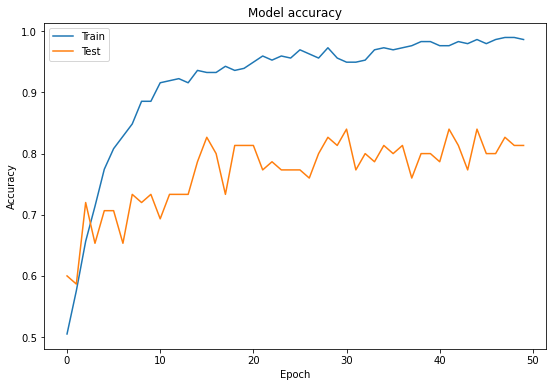

In [200]:
# Plot training & validation accuracy values
plt.figure(figsize=(9,6))
plt.plot(GRU_history.history['accuracy'])
plt.plot(GRU_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

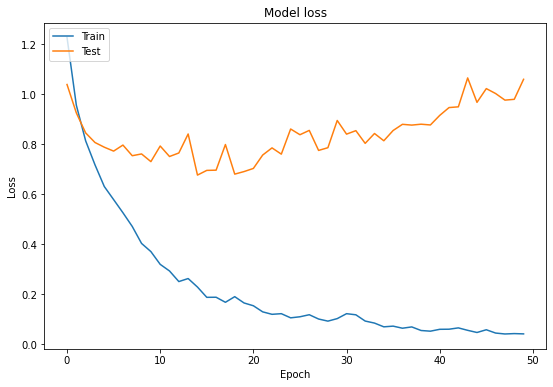

In [201]:
# Plot training & validation loss values
plt.figure(figsize=(9,6))
plt.plot(GRU_history.history['loss'])
plt.plot(GRU_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [202]:
y_pred_GRU = GRU_model.predict(feature_test)
y_pred_GRU_class = np.argmax(y_pred_GRU, axis=1)

3/3 [==============================] - 2s 18ms/step


In [203]:
print(accuracy_score(y_test_class, y_pred_GRU_class))
print(classification_report(y_test_class, y_pred_GRU_class))

0.8172043010752689
              precision    recall  f1-score   support

           0       0.67      0.63      0.65        19
           1       0.85      0.88      0.86        50
           2       0.87      0.87      0.87        23
           3       0.00      0.00      0.00         1

    accuracy                           0.82        93
   macro avg       0.60      0.60      0.60        93
weighted avg       0.81      0.82      0.81        93



/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pjw22/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 7. Only use 3 classes to do Classification.

In [67]:
# remove the 4th class and do the same process again 

df_label = pd.read_csv('/Users/pjw22/Desktop/BU Course/815/NLP_app/MutualFundLabels.csv')

df_label = df_label[df_label['Ivestment Strategy'] != 'Commodities Fund (Low Risk)']
df_label = df_label[df_label['Ivestment Strategy'] != 'Long Short Funds (High Risk)']

# We create here the dataframe that contains the summaries along with their labels
df_extraction = pd.DataFrame({'fund_name' : fund_names, 'summary':summaries})
df = df_label.merge(df_extraction, on='fund_name', how='left').dropna()

df.head()

,id,fund_name,Performance fee?,Ivestment Strategy,Leverage?,Portfolio composition,Concentration,summary
0,0000051931-18-000151,American Funds College 2018 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2018 Fund\n\nInvestment...
1,0000051931-18-000151,American Funds College 2021 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2021 Fund\n\nInvestment...
2,0000051931-18-000151,American Funds College 2024 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2024 Fund\n\nInvestment...
3,0000051931-18-000151,American Funds College 2027 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2027 Fund\n\nInvestment...
4,0000051931-18-000151,American Funds College 2030 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2030 Fund\n\nInvestment...


In [68]:
df['Ivestment Strategy'].value_counts()

Equity Long Only (Low Risk)          247
Fixed Income Long Only (Low Risk)    130
Balanced Fund (Low Risk)              84
Name: Ivestment Strategy, dtype: int64

In [69]:
# train test validation split

df_train, df_test = train_test_split(df, test_size = 0.2, random_state=41)
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=40)

In [70]:
train_summaries = list(df_train['summary'])

In [71]:
text_words = np.concatenate([tokenizer(summary) for summary in train_summaries])

In [72]:
# Build the dictionary and replace rare words with UNK token
count = [('UNK', -1)]
# Retrieve the most common words
count.extend(collections.Counter(text_words).most_common(max_vocabulary_size - 1))
# Remove samples with less than 'min_occurrence' occurrences
for i in range(len(count) - 1, -1, -1):
    if count[i][1] < min_occurrence:
        count.pop(i)
    else:
        # The collection is ordered, so stop when 'min_occurrence' is reached
        break

In [73]:
word2id = dict()
for i, (word, _)in enumerate(count):
    word2id[word] = i
id2word = dict(zip(word2id.values(), word2id.keys()))
vocab_size = len(id2word)

In [74]:
# create data
data = list()
unk_count = 0
for word in text_words:
    # Retrieve a word id, or assign it index 0 ('UNK') if not in dictionary
    index = word2id.get(word, 0)
    if index == 0:
        unk_count += 1
    data.append(index)
count[0] = ('UNK', unk_count)

In [75]:
encoder, autoencoder = creat_word2vec_model()

In [76]:
autoencoder.fit_generator(batch_generator(batch_size, num_skips, skip_window, vocab_size), steps_per_epoch=ceil(len(data) / batch_size), epochs=num_epochs)

/var/folders/l_/7bxj1ry51hbcvpybp93hdq4w0000gn/T/ipykernel_42137/486976267.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  autoencoder.fit_generator(batch_generator(batch_size, num_skips, skip_window, vocab_size), steps_per_epoch=ceil(len(data) / batch_size), epochs=num_epochs)


Epoch 1/2
4018/4018 [==============================] - 26s 6ms/step - loss: 6.4972
Epoch 2/2
4018/4018 [==============================] - 29s 7ms/step - loss: 5.9765


In [77]:
# Create the Vectorizer function (prediciton of the encoder)
def vecotrize(word):
    word_one_hot = to_one_hot(word2id[word], vocab_size)
    return encoder.predict(np.array([word_one_hot]))[0]


# Create the word2vec dictionary
word2vec = {w : vecotrize(w) for w in word2id.keys()}

# This dictionary gives for all words it's vectorial representation.


our_word2vec = 'word2vec_perso.txt'

# We can save the word2vec dictionary to reuse it later.
save_word2vec(our_word2vec)

1/1 [==============================] - 0s 19ms/step


In [78]:
# keywords for “Balanced Fund (Low Risk)”
key_words1 = ['portfolio', 'balanced', 'asset', 'diversification', 'risk', 'low', 'investment', 'strategy', 'fixed', 'income', 'equity', 'return', 'fund', 'conservative', 'market']

# keywords for “Fixed Income Long Only (Low Risk)”
key_words2 = ['portfolio', 'risk', 'low', 'investment', 'strategy', 'cash', 'fixed', 'income', 'bond', 'yield', 'credit', 'maturity', 'duration', 'treasury', 'interest', 'rate', 'corporate', 'inflation', 'economic']

# keywords for “Equity Long Only (Low Risk)”
key_words3 = ['equity', 'stocks', 'securities', 'earnings', 'dividend', 'financial', 'statement', 'revenue', 'price', 'volatility', 'fund', 'company', 'industry', 'economic', 'growth', 'sector', 'strategy', 'risk', 'portfolio', 'factor']

In [79]:
#word2vec = load_word2vec(our_word2vec)
knowledge_base1 = create_knowledge_base(5, word2vec, key_words1)
knowledge_base2 = create_knowledge_base(5, word2vec, key_words2)
knowledge_base3 = create_knowledge_base(5, word2vec, key_words3)

In [80]:
knowledge_base = knowledge_base1.union(knowledge_base2).union(knowledge_base3)

In [81]:
# It takes several minutes (5-10 minutes)
df_train['sentences_distance'] = df_train.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)

df_val['sentences_distance'] = df_val.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)

df_test['sentences_distance'] = df_test.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)

In [82]:
X_train = df_train['sentences_distance'].values
X_val = df_val['sentences_distance'].values
X_test = df_test['sentences_distance'].values

# X = df['deriv_sentences_distance'].values # uncomment to use the first sentence extraction method.
# Clean the texts
X_train = [' '.join(tokenizer(txt)) for txt in X_train]
X_val = [' '.join(tokenizer(txt)) for txt in X_val]
X_test = [' '.join(tokenizer(txt)) for txt in X_test]

X_train[0][:100]

'iico also consider effect commodity price trends certain holdings poor capital management whether co'

In [83]:
# one-hot for labels

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)

y_train = encoder.fit_transform(np.array(df_train['Ivestment Strategy']).reshape(-1,1))
y_val = encoder.fit_transform(np.array(df_val['Ivestment Strategy']).reshape(-1,1))
y_test = encoder.fit_transform(np.array(df_test['Ivestment Strategy']).reshape(-1,1))


In [84]:
# The Tokenizer provided by the Keras library allows to perform such transformation.
keras_tokenizer = Tokenizer(num_words=num_words)
keras_tokenizer.fit_on_texts(X_train)
# word_index is the dictionary that contains the index of each words in our 2500 long vocabulary.
word_index = keras_tokenizer.word_index
sequences_train = keras_tokenizer.texts_to_sequences(X_train)
sequences_test = keras_tokenizer.texts_to_sequences(X_test)
sequences_val = keras_tokenizer.texts_to_sequences(X_val)

In [85]:
feature_train = pad_sequences(sequences_train, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_test = pad_sequences(sequences_test, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_val = pad_sequences(sequences_val, maxlen=maxlen, dtype=float, padding='post', truncating='post')

In [86]:
embedding_matrix = np.zeros((len(word_index) + 1, word_dimension))
for word, i in word_index.items():
    embedding_vector = word2vec_g.get(word)
    #embedding_vector = word2vec.get(word)   # uncomment to use our own word2vec
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

CNN

In [125]:
def create_CNN_model():
    CNN = Sequential()
    # The Embedding layer takes the embedding matrix as an argument and transform the inputed the sequences of index to sequences of vectors.
    CNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=False))


    CNN.add(Convolution1D(64, 5, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))

    CNN.add(Convolution1D(32, 5, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))

    CNN.add(Flatten())
    CNN.add(Dense(units = 128 , activation = 'relu'))
    CNN.add(Dropout(0.5))

    #CNN.add(Dense(units = 1, activation = 'sigmoid'))
    CNN.add(Dense(units = 3, activation = 'sigmoid'))

    CNN.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return CNN

CNN_model = create_CNN_model()

In [126]:
CNN_history = CNN_model.fit(feature_train, y_train, epochs=50, batch_size=16, validation_data=(feature_val, y_val))

Epoch 1/50
19/19 [==============================] - 1s 31ms/step - loss: 1.0336 - accuracy: 0.5340 - val_loss: 0.8594 - val_accuracy: 0.6081
Epoch 2/50
19/19 [==============================] - 0s 7ms/step - loss: 0.7459 - accuracy: 0.7041 - val_loss: 0.8420 - val_accuracy: 0.6486
Epoch 3/50
19/19 [==============================] - 0s 7ms/step - loss: 0.5770 - accuracy: 0.7823 - val_loss: 0.6827 - val_accuracy: 0.8108
Epoch 4/50
19/19 [==============================] - 0s 5ms/step - loss: 0.3833 - accuracy: 0.8639 - val_loss: 0.6680 - val_accuracy: 0.8108
Epoch 5/50
19/19 [==============================] - 0s 5ms/step - loss: 0.3591 - accuracy: 0.8605 - val_loss: 0.8670 - val_accuracy: 0.7162
Epoch 6/50
19/19 [==============================] - 0s 6ms/step - loss: 0.2794 - accuracy: 0.9082 - val_loss: 0.5607 - val_accuracy: 0.7973
Epoch 7/50
19/19 [==============================] - 0s 8ms/step - loss: 0.1411 - accuracy: 0.9626 - val_loss: 0.6286 - val_accuracy: 0.8649
Epoch 8/50
19/19 [=

In [127]:
y_pred_CNN = CNN_model.predict(feature_test)
y_pred_CNN_class = np.argmax(y_pred_CNN, axis=1)
y_test_class = np.argmax(y_test, axis=1)

print(accuracy_score(y_test_class, y_pred_CNN_class))
print(classification_report(y_test_class, y_pred_CNN_class))

3/3 [==============================] - 0s 3ms/step
0.8709677419354839
              precision    recall  f1-score   support

           0       0.87      0.68      0.76        19
           1       0.85      0.98      0.91        46
           2       0.92      0.82      0.87        28

    accuracy                           0.87        93
   macro avg       0.88      0.83      0.85        93
weighted avg       0.87      0.87      0.87        93



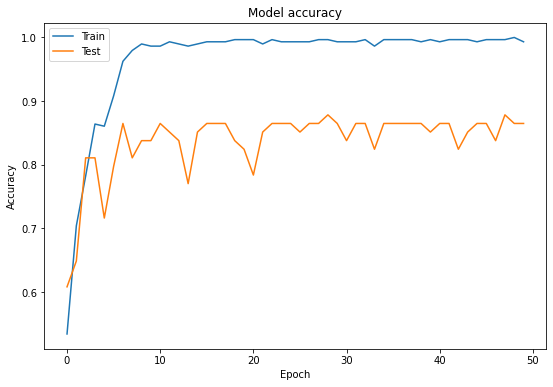

In [128]:
# Plot training & validation accuracy
plt.figure(figsize=(9,6))
plt.plot(CNN_history.history['accuracy'])
plt.plot(CNN_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

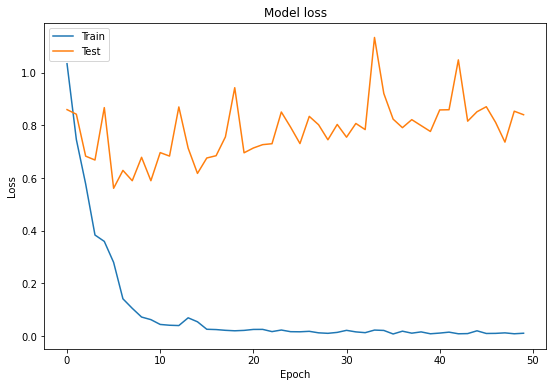

In [129]:
# Plot training & validation loss values
plt.figure(figsize=(9,6))
plt.plot(CNN_history.history['loss'])
plt.plot(CNN_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

LSTM

In [122]:
def create_RNN_model():
    RNN = Sequential()
    RNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=False))

    RNN.add(Bidirectional(LSTM(word_dimension)))
    RNN.add(Dense(word_dimension, activation='relu'))
    RNN.add(Dense(3, activation='sigmoid'))
    RNN.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    #RNN.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
    
    return RNN

In [123]:
RNN_model = create_RNN_model()
RNN_history = RNN_model.fit(feature_train, y_train, epochs=50, batch_size=16, validation_data=(feature_val, y_val))

Epoch 1/50
19/19 [==============================] - 5s 115ms/step - loss: 1.0662 - accuracy: 0.4456 - val_loss: 0.9603 - val_accuracy: 0.5541
Epoch 2/50
19/19 [==============================] - 1s 38ms/step - loss: 0.8304 - accuracy: 0.6429 - val_loss: 0.8713 - val_accuracy: 0.5946
Epoch 3/50
19/19 [==============================] - 1s 65ms/step - loss: 0.6492 - accuracy: 0.7483 - val_loss: 0.8075 - val_accuracy: 0.6622
Epoch 4/50
19/19 [==============================] - 1s 35ms/step - loss: 0.5263 - accuracy: 0.8197 - val_loss: 0.7569 - val_accuracy: 0.7297
Epoch 5/50
19/19 [==============================] - 1s 35ms/step - loss: 0.4661 - accuracy: 0.8605 - val_loss: 0.6191 - val_accuracy: 0.8243
Epoch 6/50
19/19 [==============================] - 1s 35ms/step - loss: 0.4666 - accuracy: 0.8469 - val_loss: 0.7052 - val_accuracy: 0.7297
Epoch 7/50
19/19 [==============================] - 1s 41ms/step - loss: 0.3715 - accuracy: 0.8707 - val_loss: 0.6666 - val_accuracy: 0.7973
Epoch 8/50
1

In [124]:
y_pred_RNN = RNN_model.predict(feature_test)
y_pred_RNN_class = np.argmax(y_pred_RNN, axis=1)

print(accuracy_score(y_test_class, y_pred_RNN_class))
print(classification_report(y_test_class, y_pred_RNN_class))

3/3 [==============================] - 1s 15ms/step
0.8494623655913979
              precision    recall  f1-score   support

           0       0.81      0.68      0.74        19
           1       0.83      0.93      0.88        46
           2       0.92      0.82      0.87        28

    accuracy                           0.85        93
   macro avg       0.85      0.81      0.83        93
weighted avg       0.85      0.85      0.85        93



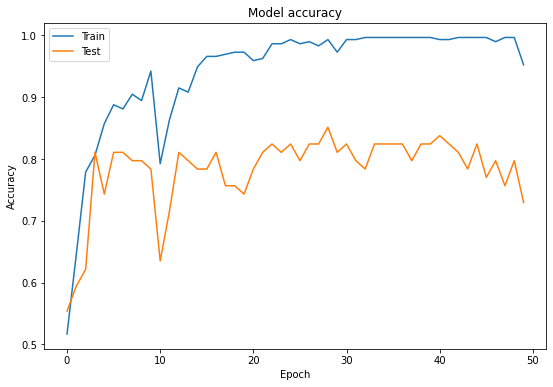

In [120]:
# Plot training & validation accuracy values
plt.figure(figsize=(9,6))
plt.plot(RNN_history.history['accuracy'])
plt.plot(RNN_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

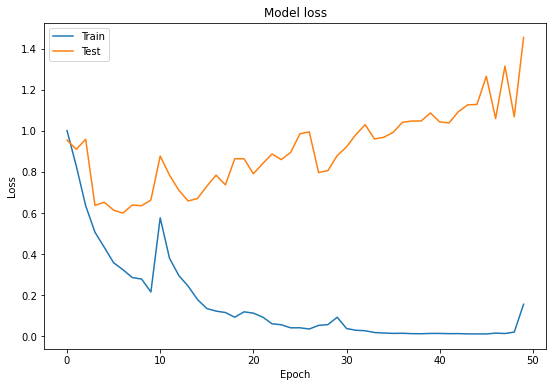

In [121]:
# Plot training & validation loss values
plt.figure(figsize=(9,6))
plt.plot(RNN_history.history['loss'])
plt.plot(RNN_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

GRU

In [112]:
def create_GRU_model():
    RNN = Sequential()
    RNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=False))

    RNN.add(Bidirectional(GRU(word_dimension)))
    RNN.add(Dense(word_dimension, activation='relu'))
    RNN.add(Dense(3, activation='sigmoid'))
    RNN.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    #RNN.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
    
    return RNN

In [113]:
GRU_model = create_GRU_model()
GRU_history = GRU_model.fit(feature_train, y_train, epochs=50, batch_size=16, validation_data=(feature_val, y_val))

Epoch 1/50
19/19 [==============================] - 4s 103ms/step - loss: 0.9818 - accuracy: 0.5612 - val_loss: 0.9372 - val_accuracy: 0.5541
Epoch 2/50
19/19 [==============================] - 1s 50ms/step - loss: 0.8272 - accuracy: 0.5952 - val_loss: 0.8711 - val_accuracy: 0.6351
Epoch 3/50
19/19 [==============================] - 1s 43ms/step - loss: 0.7165 - accuracy: 0.7245 - val_loss: 0.8408 - val_accuracy: 0.6622
Epoch 4/50
19/19 [==============================] - 1s 50ms/step - loss: 0.6233 - accuracy: 0.7993 - val_loss: 0.8103 - val_accuracy: 0.6757
Epoch 5/50
19/19 [==============================] - 1s 58ms/step - loss: 0.5361 - accuracy: 0.8231 - val_loss: 0.8347 - val_accuracy: 0.7027
Epoch 6/50
19/19 [==============================] - 1s 51ms/step - loss: 0.4918 - accuracy: 0.8469 - val_loss: 0.7990 - val_accuracy: 0.6486
Epoch 7/50
19/19 [==============================] - 1s 44ms/step - loss: 0.4078 - accuracy: 0.8707 - val_loss: 0.8002 - val_accuracy: 0.6892
Epoch 8/50
1

In [114]:
y_pred_GRU = GRU_model.predict(feature_test)
y_pred_GRU_class = np.argmax(y_pred_GRU, axis=1)

print(accuracy_score(y_test_class, y_pred_GRU_class))
print(classification_report(y_test_class, y_pred_GRU_class))

3/3 [==============================] - 1s 11ms/step
0.8387096774193549
              precision    recall  f1-score   support

           0       0.92      0.63      0.75        19
           1       0.79      0.98      0.87        46
           2       0.91      0.75      0.82        28

    accuracy                           0.84        93
   macro avg       0.88      0.79      0.82        93
weighted avg       0.85      0.84      0.83        93



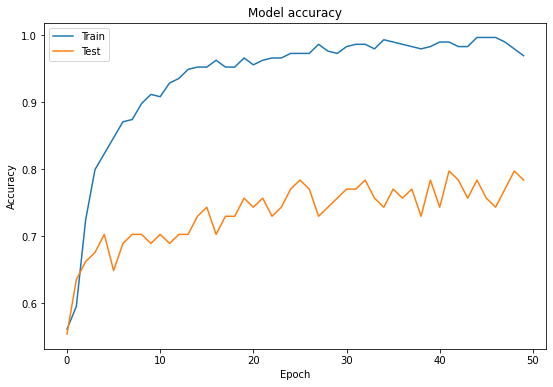

In [115]:
# Plot training & validation accuracy values
plt.figure(figsize=(9,6))
plt.plot(GRU_history.history['accuracy'])
plt.plot(GRU_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

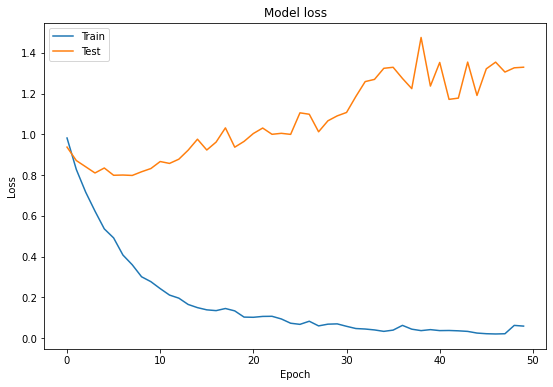

In [116]:
# Plot training & validation loss values
plt.figure(figsize=(9,6))
plt.plot(GRU_history.history['loss'])
plt.plot(GRU_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()